# Stoneburner, Kurt #
- ## DSC 550 - Week 07
- ## Milestone #4

### Current Project Goals: ###
**Primary Goal**: Model Racial COVID numbers at the county level. California provides County COVID data in terms of total case data. I want to model the racial makeup of those case. Example: If there were 100 COVID cases, I want to estimate the Latino, White, Black and Asian cases for the county. 

I thought this task would be fairly easy. After a very intense week I kind of have a path on a model. I had some success by running a manual model. First, I calculated the statewide racial portion of all COVID cases. Example: Latino: .45, White: .22, Black: .05 etc. This value is calculated for each day across the data set.

The model takes the expected race cases for each county/day and adjusts each value by the statewide racial percentage: Expected Cases + (Expected cases * state racial modifier). To score the model, I've generated an 'est' attribute than is a sum() of the adjusted racial cases. This value is compared the to actual values. I have not generated any numeric error scores yet. I would use a sum of mean squares method to score the model error. Towards the bottom of this document is a graph for each county of actual vs modeled values ordered by COVID prevalence. 

The model appears to work pretty well in counties with a high COVID prevalence. It tends to be much less accurate in less COVID prevalent counties. This could be an error in my math, scaling, or these counties are less influenced by racial effects.

### Note: ###
This is very much a work in progress. I left a lot of dead end code in here. Most the graphs demonstrate that I was on the wrong path. There is a lot of trial and error here. I did a fair bit of Linear Regression that simply failed. 

I'm chasing the COVID data trying to make the best sense of it that I can. I've learned quite a bit about scaling and the racial inequity of COVID. There is a graph below referencing scaling. Unscaled COVID cases by race show White people as having the second highest COVID counts. When scaled to cases per 100k, Whites have the lowest prevalence of COVID cases. That hit me full stop and inspired a conversation with a newscast Producer.

I'm going to try and run this model on scaled data, then look at maybe using a linear regression or forest regression model to see if I can predict actual COVID cases based on the generated adjusted COVID values.

I feel like I'm chasing something worthy, although I may be veering away from the intent of this assignment. I could really use some advice if I'm heading in the right direction.

In [1]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)


In [2]:
# //*** Legends automatically generate too many labels based on my looping method.
# //*** Remove the Duplicate Legends. I wrote this for DSC 530 and it keeps on giving.
def deduplicate_legend(input_ax):
    # //**** Get handle and label list for the current legend
    # //**** Use first instance, toss the rest.
    handles, labels = input_ax.get_legend_handles_labels()

    handle_dict = {}

    for x in range(len(labels)):
        if labels[x] not in handle_dict.keys():
            # //*** Label = handle
            handle_dict[labels[x]] = handles[x]

    # //*** Build unique output ists and handles
    out_handles = []
    out_labels = []
    
    for label,handle in handle_dict.items():
        out_handles.append(handle)
        out_labels.append(label)
    
    return out_handles,out_labels

   

In [3]:
#//*** Only download Data if download_data is True.
#//*** Avoids needlessly generating HTTP traffic
download_data = False
demographic_data_filename = "z_ca_covid_demo.csv"
cases_data_filename = "z_ca_covid_cases.csv"

#//***********************************************************************************************
#//*** California COVID Data website:
#//**************************************
#//*** https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state
#//***********************************************************************************************

#//*** Download California Current COVID Demograohic Data
if download_data:
    try:
        response = requests.get("https://data.chhs.ca.gov/dataset/f333528b-4d38-4814-bebb-12db1f10f535/resource/e2c6a86b-d269-4ce1-b484-570353265183/download/covid19casesdemographics.csv")
        if response.ok:
            print("Demographic Data Downloaded")
            f = open(demographic_data_filename, "w")
            f.write(response.text)
            f.close()
            print("Demographic Data Written to file.")
    except:
        print("Demographic Data: Trouble Downloading From State of CA")

#//*** Download California Current COVID Case Counts
    try:
        response = requests.get("https://data.chhs.ca.gov/dataset/f333528b-4d38-4814-bebb-12db1f10f535/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a/download/covid19cases_test.csv")
        if response.ok:
            print("Case Data Downloaded")
            f = open(cases_data_filename, "w")
            f.write(response.text)
            f.close()
            print("Case Data Written to file.")
    except:
        print("Ca Case Data: Trouble Downloading From State of CA")

In [4]:
ca_covid_df= pd.read_csv(cases_data_filename)
ca_race_df = pd.read_csv(demographic_data_filename)
print(ca_race_df.columns)
#//*** Demographics Contain Age Groups, Gender, and Race Ethnicity.

#//*** We'll Focus on just Race Ethnicicty
print(f"Demographic Types: {ca_race_df['demographic_category'].unique()}")

#//*** Get Just Race Ethnicity
race_category = ca_race_df['demographic_category'].unique()[2]

ca_race_df = ca_race_df[ca_race_df['demographic_category'] == race_category]


Index(['demographic_category', 'demographic_value', 'total_cases', 'percent_cases', 'deaths', 'percent_deaths', 'percent_of_ca_population', 'report_date'], dtype='object')
Demographic Types: ['Age Group' 'Gender' 'Race Ethnicity']


In [5]:
#//**********************************************************************************************************************************
#//*** US Census data on Racial population by County in California
#//**********************************************************************************************************************************
#//*** Data Source
#//**********************************************************************************************************************************
#//*** Census Data: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-detail.html
#//*** Direct Download: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata-06.csv
#//**********************************************************************************************************************************
#//*** Process Flat File: California Ethnicity demographics - cc-est2019-alldata-06.csv

raw_ethnic_pop_df = pd.read_csv("cc-est2019-alldata-06.csv")

#//*** Data includes values for last twelve years. We only want data for the last year.

#//*** Rebuild raw_ethnic_pop_df using only the last year (most recent) data
raw_ethnic_pop_df = raw_ethnic_pop_df[raw_ethnic_pop_df['YEAR']==raw_ethnic_pop_df['YEAR'].max()]

#//*** Ethnic data is broken down by age. At this stage we will only use the totals of all ages
#//*** Only use AGEGRP == 0
raw_ethnic_pop_df = raw_ethnic_pop_df[raw_ethnic_pop_df['AGEGRP']==raw_ethnic_pop_df['AGEGRP'].min()]

#//*** Demographics are based on gender as well as Federal Race and Ethnic attributes. These attributes are different than the values reported
#//*** By the State of California. These attributes will require cleaning and transformation.
raw_ethnic_pop_df.head(20)

SUMLEV  STATE  COUNTY      STNAME              CTYNAME  YEAR  AGEGRP   TOT_POP  TOT_MALE  TOT_FEMALE  WA_MALE  WA_FEMALE  BA_MALE  BA_FEMALE  IA_MALE  IA_FEMALE  AA_MALE  AA_FEMALE  NA_MALE  \
209       50      6       1  California       Alameda County    12       0   1671329    823247      848082   414416     409177    88167      96201     9048       8749   259991     280400     7534   
437       50      6       3  California        Alpine County    12       0      1129       609         520      424        343        0          4      146        144       11          7        0   
665       50      6       5  California        Amador County    12       0     39752     21638       18114    19053      16583      955        111      554        371      318        347       61   
893       50      6       7  California         Butte County    12       0    219186    108473      110713    92754      94988     2316       1842     2730       2817     5461       5523      316   
1121      50      6       9  California     Calaveras County    12       0     45905     22847       23058    20794      20958      303        195      428        477      390        469       58   
1349      50      6      11  California        Colusa County    12       0     21547     10975       10572    10011       9619      164        118      312        282      152        185       63   
1577      50      6      13  California  Contra Costa County    12       0   1153526    564187      589339   372197     379086    52267      57797     5984       5725    99630     111488     3416   
1805      50      6      15  California     Del Norte County    12       0     27812     15186       12626    11674      10046      884         96     1415       1277      410        451       23   
2033      50      6      17  California     El Dorado County    12       0    192843     96158       96685    85557      85379     1142        858     1340       1234     4128       5189      223   
2261      50      6      19  California        Fresno County    12       0    999101    498648      500453   382292     382910    29301      28675    14838      14887    54900      56453     1422   
2489      50      6      21  California         Glenn County    12       0     28393     14462       13931    12881      12411      226        151      464        451      442        448       30   
2717      50      6      23  California      Humboldt County    12       0    135558     67241       68317    56089      56741     1161        857     4159       4478     1852       2078      231   
2945      50      6      25  California      Imperial County    12       0    181215     92878       88337    82621      80823     4317       1692     2216       2280     1967       1856      194   
3173      50      6      27  California          Inyo County    12       0     18039      9036        9003     7263       7141      136         83     1169       1267      143        164       18   
3401      50      6      29  California          Kern County    12       0    900202    461034      439168   379621     361338    30296      25986    11946      11772    23750      24529     1216   
3629      50      6      31  California         Kings County    12       0    152940     84342       68598    67356      56291     7772       3645     2574       2331     3301       3413      269   
3857      50      6      33  California          Lake County    12       0     64386     32194       32192    27976      28072      746        605     1454       1426      412        476       94   
4085      50      6      35  California        Lassen County    12       0     30573     19026       11547    14780       9960     2393        176      787        514      268        221      134   
4313      50      6      37  California   Los Angeles County    12       0  10039107   4949041     5090066  3552806    3545503   426817     472349    73361      70607   722516     822929    18174   
4541      50      6      3

In [6]:
#//*** Convert Applicable federal based census codes to California Census Codes.
#//*** Description of Federal Column Values
#//*** https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf
#//*** Census Data: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/

#//*** Notably, Federal census regards Hispanic as an ethnicity not a race. For Example: People can be Hispanic White,
#//*** Hispanic Black, or Hispanic Asian.
#//*** California treats all hispanics as Latino
#//*** Latino = H_MALE, H_FEMALE Hispanic
#//*** White - NHWA_MALE, NHWA_FEMALE (Not Hispanic White)
#//*** Asian - NHAA_MALE, NHAA_FEMALE (Not Hispanic Asian) 
#//*** Black - NHBA_MALE, NHBA_FEMALE (Not Hispanic Black) 

#//*** Amer Indian - NHIA_MALE, NHIA_FEMALE (Not Hispanic, American Indian) 

#//*** Hawaiian - NHNA_MALE, NHNA_FEMALE (Not Hispanic, Hawaiian) 

#//*** California has the following columns: Multiracial, Other, Multirace. I could not find a good definition of these
#//*** These represent less than 5% of the population. Small but not too small to be ignored. These will combined into
#//*** Single attribute Other and combined with NHTOM_MALE, NHTOM_FEMALE - Not Hispanic Two or more races

#//*** Build a new data frame to hold the sanitized values.
pop_attrib_df = pd.DataFrame()

#//*** The County Fibs code is shared between the federal census data and the Community Resilliance Estimate
pop_attrib_df['cty_fibs'] = raw_ethnic_pop_df['COUNTY']

#//*** County Name will be the Common attribute to link to the timeseries Data.
#//*** Standardize the County name. Remove County from the column name 
pop_attrib_df['county'] = raw_ethnic_pop_df['CTYNAME'].str.replace(" County","")
pop_attrib_df['population'] = raw_ethnic_pop_df['TOT_POP']

clean_cols = { 'Latino' : ['H_MALE', 'H_FEMALE'], 
              'White' : ['NHWA_MALE', 'NHWA_FEMALE'],
              'Asian' : ['NHAA_MALE', 'NHAA_FEMALE'],
              'Black' : ['NHBA_MALE', 'NHBA_FEMALE'],
              'Native' : ['NHIA_MALE','NHIA_FEMALE'],
              'Hawaiian' : ['NHNA_MALE', 'NHNA_FEMALE'],
              'Multiracial' : ['NHTOM_MALE', 'NHTOM_FEMALE']
            
            }

#//*** Combine male and female columns and store to column with same name as California Data
#//*** Loop through the clean_cols dictionary, key is California name, value is Federal columns to combine
#//*** These are the easy 1:1 columns
#//*** Hawaiian and Other will need adjustment in the Califnornia Side of the Dataset.


#//*** California Column name = Federal category male + Federal Category female
for ca_name,fed_names in clean_cols.items():
    pop_attrib_df[ca_name] = raw_ethnic_pop_df[fed_names[0]] + raw_ethnic_pop_df[fed_names[1]] 

#              'Native Hawaiian or Pacific Islander' :
#              'Native Hawaiian and other Pacific Islander'
#            'Other'

#//*** Assign the index to the county fibs number
pop_attrib_df = pop_attrib_df.set_index('cty_fibs')

In [7]:
#//***********************
#//*** Working Data Sets
#//*********************************
#//*** County Population by Race
#//*********************************

print(pop_attrib_df.head(20))




                county  population   Latino    White    Asian   Black  Native  Hawaiian  Multiracial
cty_fibs                                                                                            
1              Alameda     1671329   373055   512134   529698  169954    4157     13474        68857
3               Alpine        1129      139      692       18       4     243         0           33
5               Amador       39752     5753    30742      575     994     606        83          999
7                Butte      219186    37731   155415    10573    3526    3390       465         8086
9            Calaveras       45905     5967    36672      719     420     562        98         1467
11              Colusa       21547    13018     7344      266     220     293        73          333
13        Contra Costa     1153526   300420   492393   204045  100798    3126      5379        47365
15           Del Norte       27812     5596    17236      802     917    2059        42    

In [8]:
#//****************************************
#//*** Cleanup Statewide COVID attributes
#//****************************************
if 'demographic_value' in ca_race_df.columns:
    #//*** Rename the California Racial names to matches the census derived attribute names in pop_attrib_df
    ca_race_df['demographic_value']=ca_race_df['demographic_value'].str.replace('Native Hawaiian and other Pacific Islander','Hawaiian')
    ca_race_df['demographic_value']=ca_race_df['demographic_value'].str.replace('Multi-Race','Multiracial' )
    ca_race_df['demographic_value']=ca_race_df['demographic_value'].str.replace('American Indian or Alaska Native','Native' ) 

#//*** rename the reported_date column
ca_race_df.rename( columns= {'report_date':'date','total_cases':'cum_cases','deaths':'cum_deaths'}, inplace=True)

if 'demographic_category' in ca_race_df.columns:
    del ca_race_df['demographic_category']

if 'demographic_value' in ca_race_df.columns:
    print(ca_race_df['demographic_value'].unique())

#//*************************************
#//*** Cleanup Statewide COVID values
#//*************************************
if 'demographic_value' in ca_race_df.columns:
    ca_race_df.rename( columns= {'demographic_value':'race'}, inplace=True)

#if 'total_cases' in ca_race_df.columns:
#    ca_race_df.rename( columns= {'total_cases':'cases'}, inplace=True)

remove_cols = ['percent_cases','percent_deaths','percent_of_ca_population']

#//*** Convert date to datetime format.
ca_race_df['date'] =  pd.to_datetime(ca_race_df['date'], infer_datetime_format=True)

for col in remove_cols:
    if col in ca_race_df.columns:
        del ca_race_df[col]

ca_total_df = ca_race_df[ca_race_df['race']=="Total"].copy()

if 'race' in ca_total_df.columns:
    del ca_total_df['race']

#//*** Remove Total and Other from Race Types. Total is Statewide infections, Other is other racial categories.
ca_race_df = ca_race_df[~ca_race_df['race'].isin(['Other','Total'])]

print(ca_race_df)

['Native' 'Asian' 'Black' 'Latino' 'Multiracial' 'Hawaiian' 'Other'
 'Total' 'White']
        race  cum_cases  cum_deaths       date
3800  Native         33           3 2020-04-13
3801  Native         33           3 2020-04-14
3802  Native         32           3 2020-04-15
3803  Native         34           4 2020-04-16
3804  Native         38           4 2020-04-17
...      ...        ...         ...        ...
7296   White     584541       18414 2021-05-02
7297   White     585032       18415 2021-05-03
7298   White     585496       18445 2021-05-04
7299   White     586155       18466 2021-05-05
7300   White     586926       18509 2021-05-06

[2723 rows x 4 columns]


In [9]:
#//*** Need Daily State race new totals
#//*** Loop Through each race, calculate the new cases per race and add to a running list. Once the lists are built, they are
#//*** added back to the dataframe as a series that are aligned with correct daily values.

case_list = []
death_list = []

for race in ca_race_df['race'].unique():
    loop_race_df = ca_race_df[ ca_race_df['race'] == race ].copy() 
    case_list = case_list + list(loop_race_df['cum_cases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))    
    death_list = death_list + list(loop_race_df['cum_deaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))    
    

ca_race_df['cases'] = case_list
ca_race_df['deaths'] = case_list
#print(len(case_list),len(ca_race_df))
ca_race_df = ca_race_df.dropna()


ca_race_df[ ['cases','deaths'] ] = ca_race_df[['cases','deaths']].copy().clip( lower=0)
 

#print(ca_race_df)

In [10]:
#//********************************************************************
#//*** Convert State Race Totals to State Wide per 100k values.
#//********************************************************************

state_pop = {}
print(ca_race_df['race'].unique())
for col in pop_attrib_df.columns[1:]:
    state_pop[col] = pop_attrib_df[col].sum()/100000

print(ca_race_df['race'].apply(lambda x : state_pop[x]))

ca_race_df['cases_100k'] = ca_race_df['cases'] / ca_race_df['race'].apply(lambda x : state_pop[x])
ca_race_df['deaths_100k'] = ca_race_df['deaths'] / ca_race_df['race'].apply(lambda x : state_pop[x])

#//*** temp list to hold per 100k values
#tl_case = []
#t1_death = []
#print(ca_race_df)
#for index,row in ca_race_df.iterrows():
    
    #//*** Get State population based on race column
#    state_pop[ row['race'] ]

for date in ca_race_df['date'].unique():
    print(ca_race_df[ ca_race_df['date'] == date ])
    break

['Native' 'Asian' 'Black' 'Latino' 'Multiracial' 'Hawaiian' 'White']
3801      1.62336
3802      1.62336
3803      1.62336
3804      1.62336
3805      1.62336
          ...    
7296    144.23748
7297    144.23748
7298    144.23748
7299    144.23748
7300    144.23748
Name: race, Length: 2716, dtype: float64
             race  cum_cases  cum_deaths       date  cases  deaths  cases_100k  deaths_100k
3801       Native         33           3 2020-04-14    0.0     0.0    0.000000     0.000000
4190        Asian       2045         103 2020-04-14  143.0   143.0    2.436515     2.436515
4579        Black       1107          79 2020-04-14   77.0    77.0    3.466340     3.466340
4968       Latino       5910         203 2020-04-14  634.0   634.0    4.070657     4.070657
5357  Multiracial        303           9 2020-04-14   35.0    35.0    3.140678     3.140678
5746     Hawaiian        252           6 2020-04-14    9.0     9.0    6.145484     6.145484
6913        White       4939         264 2020-04

In [11]:
#//*** Build State wide new cases

#//********************************************************************
#//*** Convert State COVID Totals to State Wide per 100k values.
#//********************************************************************
ca_total_pop = pop_attrib_df['population'].sum()
ca_total_pop_100k = ca_total_pop/100000
ca_total_df['cases'] = ca_total_df['cum_cases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
ca_total_df['deaths'] = ca_total_df['cum_deaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
#    death_list = death_list + list(loop_race_df['deaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))    

ca_total_df['cases_100k'] = ca_total_df['cases']/ca_total_pop_100k
ca_total_df['deaths_100k'] = ca_total_df['deaths']/ca_total_pop_100k
print(ca_total_df)

      cum_cases  cum_deaths       date   cases  deaths  cases_100k  deaths_100k
6523      14660         599 2020-04-13     NaN     NaN         NaN          NaN
6524      15895         683 2020-04-14  1235.0    84.0    3.125615     0.212592
6525      17017         761 2020-04-15  1122.0    78.0    2.839628     0.197407
6526      18211         851 2020-04-16  1194.0    90.0    3.021850     0.227778
6527      19352         919 2020-04-17  1141.0    68.0    2.887714     0.172099
...         ...         ...        ...     ...     ...         ...          ...
6907    2899245       59341 2021-05-02  2070.0    16.0    5.238885     0.040494
6908    2901564       59343 2021-05-03  2319.0     2.0    5.869070     0.005062
6909    2903494       59458 2021-05-04  1930.0   115.0    4.884564     0.291049
6910    2906252       59526 2021-05-05  2758.0    68.0    6.980119     0.172099
6911    2909959       59631 2021-05-06  3707.0   105.0    9.381907     0.265741

[389 rows x 7 columns]


In [12]:
#//*** Clean Ca_COVID_df
ca_covid_df.rename( columns= {'area':'county'}, inplace=True)
print(f"# of counties before Cleaning: {len(ca_covid_df['county'].unique())}")

#//*** Remove the 'Out Of State, Unknown and California' listings
print(f"Length Before removing Out Of Country County: {len(ca_covid_df)}")
ca_covid_df = ca_covid_df[~ca_covid_df['county'].isin(['Out of state','Unknown','California'])]
#covid_cases_df = covid_cases_df[~covid_cases_df['county'].isin(['Out Of Country'])]

print(f"# of counties After Cleaning: {len(ca_covid_df['county'].unique())}")

#//*** Convert Date Column to Date Type.
ca_covid_df['date'] =  pd.to_datetime(ca_covid_df['date'], infer_datetime_format=True)

#//*** Replace NaN values with 0
for col in ca_covid_df.columns:
    ca_covid_df[col].fillna(0,inplace=True)
    
#//*** Drop Columns
dropcols = ['area_type','population','positive_tests','reported_cases','reported_deaths','reported_tests']
ca_covid_orig_df = ca_covid_df.copy()

for col in dropcols:
    if col in ca_covid_df.columns:
        del ca_covid_df[col]

#print(ca_covid_df[ ca_covid_df['area_type'] == 'State'])
ca_covid_df = ca_covid_df.sort_values('date')

#\\*** DROP ca_covd dates that are not included in ca_race_df

#//*** Get first date of Race
first_date = ca_race_df.iloc[0]['date']

#//*** remove values from ca_covid before the date
ca_covid_df = ca_covid_df[ca_covid_df['date'] >= first_date].sort_values('date')
ca_total_df = ca_total_df[ca_total_df['date'] >= first_date].sort_values('date')



# of counties before Cleaning: 61
Length Before removing Out Of Country County: 28121
# of counties After Cleaning: 58


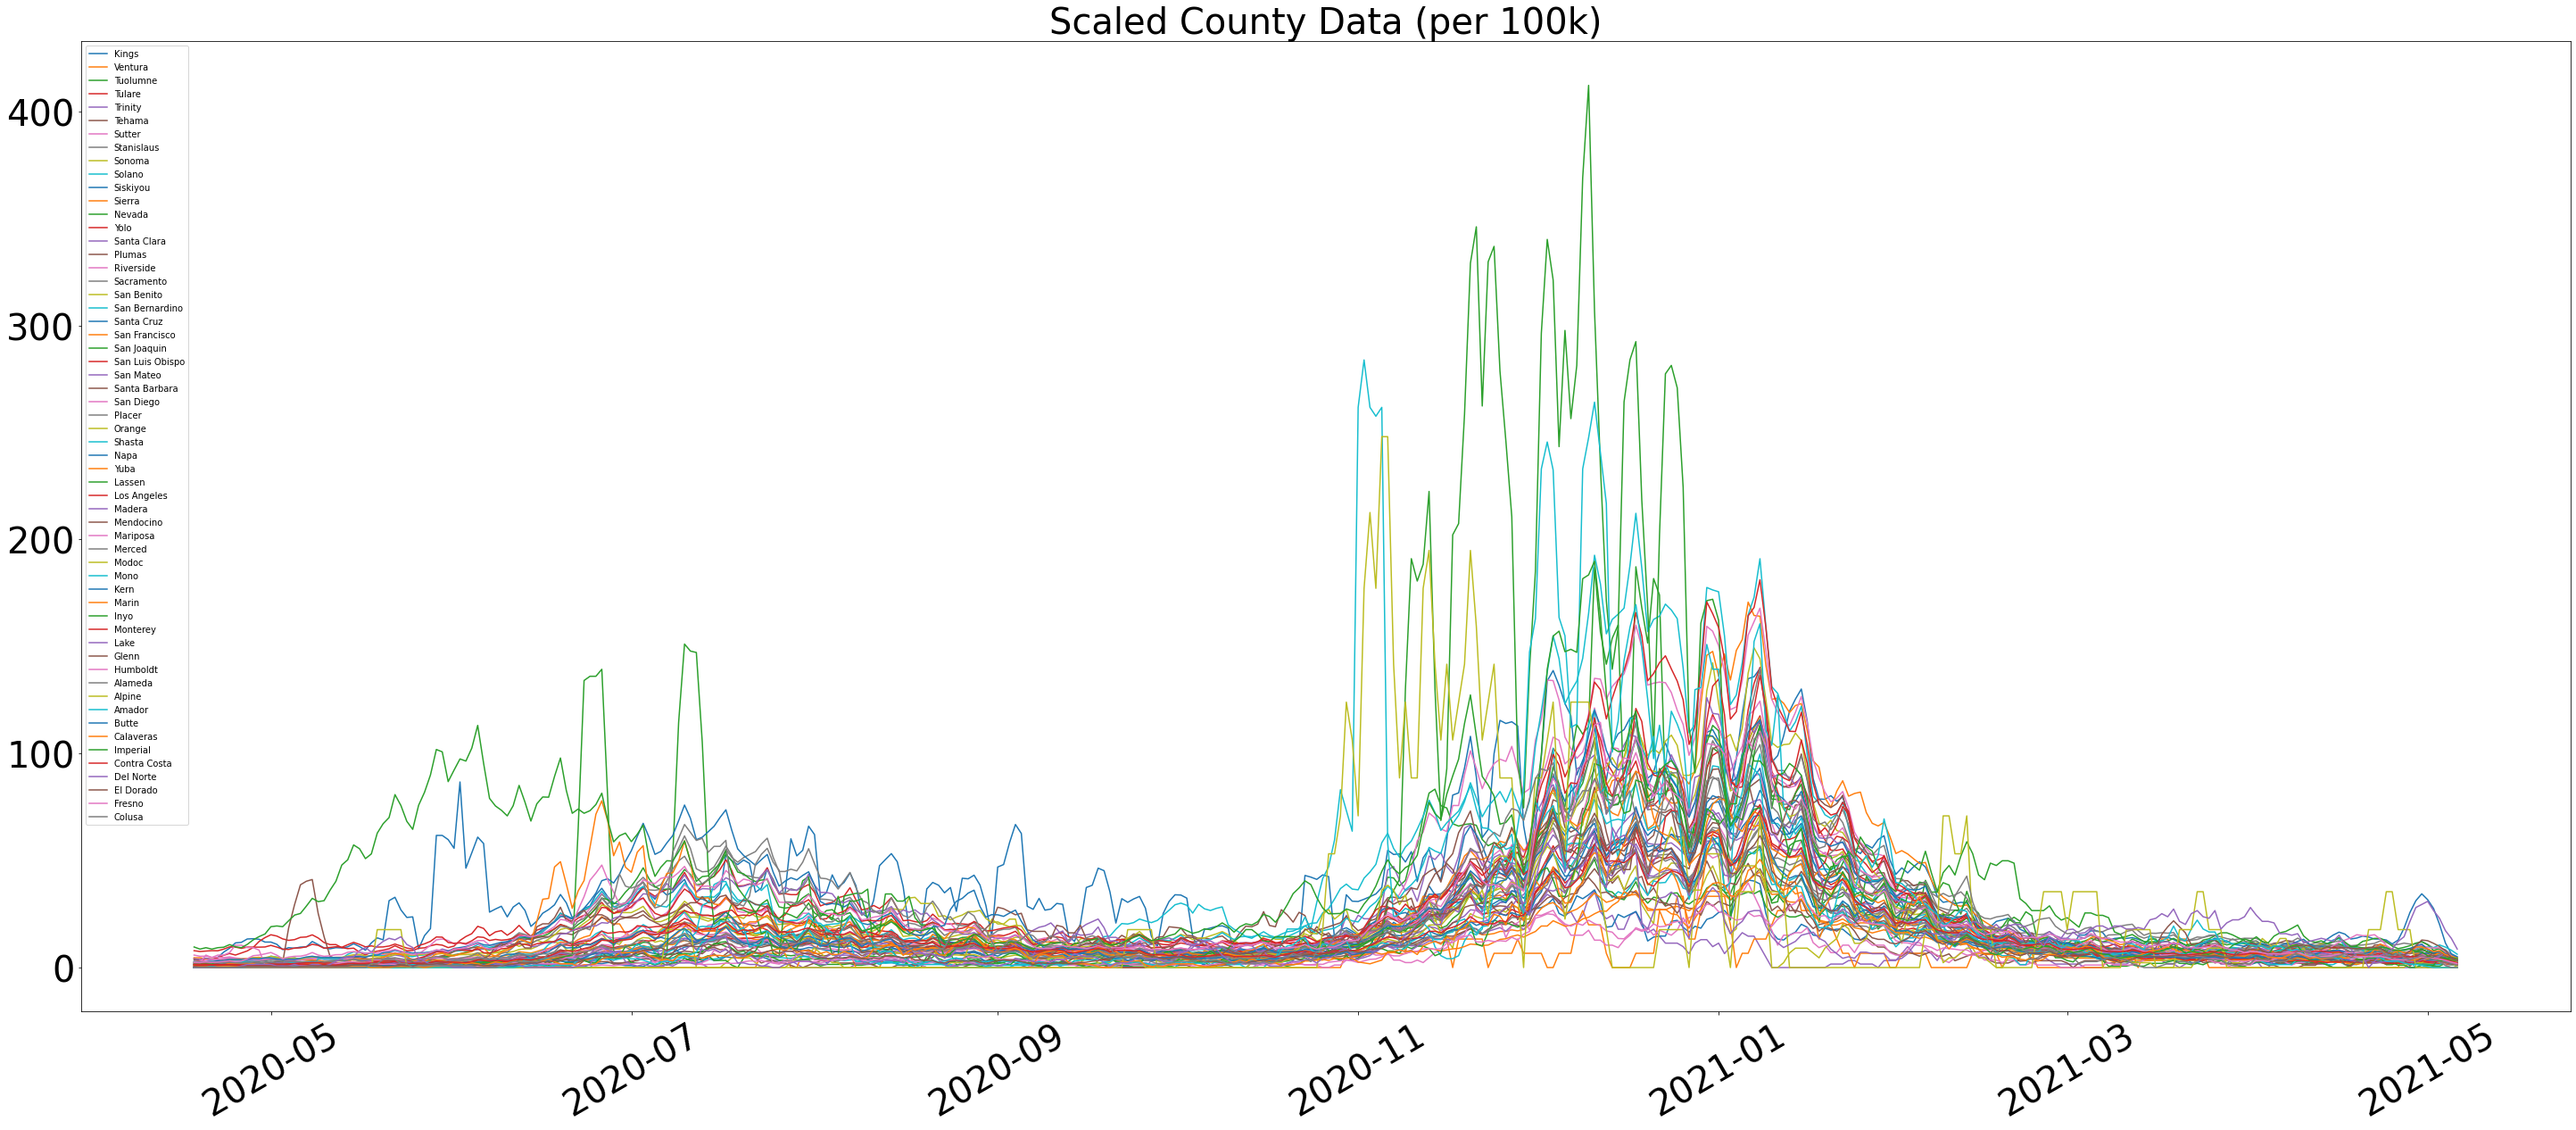

In [13]:
#//*** Merge Population Attributes with COVID County info
#//*** Only Merge if we haven't merged yet. I got 99 iPython problems but this aint one.
if "Latino" not in ca_covid_df.columns:
    ca_covid_df = pd.merge(ca_covid_df,pop_attrib_df,how="left",on=['county'])


#//*** Build per 100k Stats
ca_100k_df = ca_covid_df.copy()

#//*** Define Population Columns to convert to 100k. These Columns shouldn't change. Trying to setup a flexible
#//*** Systems where I can add other attributes later if needed
population_cols = [ 'population','Latino', 'White', 'Asian', 'Black', 'Native', 'Hawaiian','Multiracial' ]

#//*** Convert Popultion values to 100k units. ie divide by 100,000
for col in population_cols:
    ca_100k_df[col] = ca_100k_df[col]/100000



#//*** Convert cases, deaths, test to per 100k units
attrib_cols = ['date','county']

#//*** Ignore values in attrib_cols, and population_cols
#//*** Convert remianing attributes to values per 100,000.
#//*** This method makes it easier to change the 100k attributes later.
for col in ca_100k_df.columns:
    if col not in attrib_cols and col not in population_cols:
        #//*** Convert column to per 100k value. Which is Columns value divided population per 100k
        ca_100k_df[col] = ca_100k_df[col]/ca_100k_df['population'] 

plt.rcParams['figure.figsize'] = [50,20]
#//*** Check our Work.
#//*** Cases per 100k should be relatively similar in values.
display_size = 40
fig,ax = plt.subplots()

for county in ca_100k_df['county'].unique():
    
    loop_df = ca_100k_df[ca_100k_df['county'] ==  county]
    ax.plot(loop_df['date'],loop_df['cases'].rolling(5).mean(),label=county)


    plt.xticks(rotation=30,fontsize=display_size)
    plt.yticks(fontsize=display_size)
handles,labels = deduplicate_legend(ax)
plt.legend(fontsize=display_size*.25,loc='upper left')
plt.title(f"Scaled County Data (per 100k)",fontsize=display_size)
#plt.ylabel("Total Cases by County (millions)",fontsize=display_size)
plt.show()



In [14]:
ca_race_diff = pd.DataFrame()

ca_race_diff['date'] = ca_total_df['date'].copy()
print(ca_race_diff)

for race in ca_race_df['race'].unique():

    race_percent = pop_attrib_df[race].sum() / pop_attrib_df['population'].sum()
    #/  ca_total_df['cases']*race_percent
    #//**** actual Value
    
    actual = ca_race_df[ca_race_df['race']==race]['cases']
    expected = ca_total_df['cases']*race_percent
    
    #ca_race_diff['actual'] = actual.values
    #ca_race_diff['expected'] = expected.values
    ca_race_diff[race] = ( actual.values - expected.values ) / actual.values
    
    #print(pd.DataFrame([actual,expected]))
    #ax.plot(ca_race_df['date'].unique(),ca_race_df[ca_race_df['race']==race]['cases'].rolling(5).mean(),label='actual')
    #ax.plot(ca_race_df['date'].unique(),ca_total_df['cases'].rolling(5).mean()*race_percent,label='expected')
#ca_race_diff['Native'] = ca_race_diff['Native'].replace(np.inf,0)
ca_race_diff.replace([np.inf, -np.inf], 0, inplace=True)
print(ca_race_diff)

           date
6524 2020-04-14
6525 2020-04-15
6526 2020-04-16
6527 2020-04-17
6528 2020-04-18
...         ...
6907 2021-05-02
6908 2021-05-03
6909 2021-05-04
6910 2021-05-05
6911 2021-05-06

[388 rows x 1 columns]
           date    Native     Asian     Black    Latino  Multiracial  Hawaiian     White
6524 2020-04-14  0.000000 -0.282822  0.098295  0.232160     0.004796  0.491396 -0.502769
6525 2020-04-15  0.000000 -0.436714  0.085820  0.154362    -0.217118  0.584139 -0.365269
6526 2020-04-16 -1.452775  0.113232  0.012849  0.188535    -0.020478  0.739678 -0.644770
6527 2020-04-17 -0.171950 -0.324071  0.056667  0.267495    -1.298639  0.615543 -0.646311
6528 2020-04-18 -3.071524 -0.268969  0.129474  0.312269    -0.996452  0.737638 -0.924254
...         ...       ...       ...       ...       ...          ...       ...       ...
6907 2021-05-02  0.055045 -0.996572  0.286045  0.428606     0.550903  0.232771 -0.511287
6908 2021-05-03 -0.058624 -1.425760  0.246397  0.426537    -0.189190  0.

<ipython-input-14-f299850cf238>:17: RuntimeWarning: divide by zero encountered in true_divide
  ca_race_diff[race] = ( actual.values - expected.values ) / actual.values
<ipython-input-14-f299850cf238>:17: RuntimeWarning: invalid value encountered in true_divide
  ca_race_diff[race] = ( actual.values - expected.values ) / actual.values


['Native' 'Asian' 'Black' 'Latino' 'Multiracial' 'Hawaiian' 'White']
Index(['total_tests', 'population', 'Latino', 'White', 'Asian', 'Black', 'Native', 'Hawaiian', 'Multiracial'], dtype='object')
            date    county  cases  deaths  total_tests  population     Latino     White     Asian     Black    Native  Hawaiian  Multiracial        est
52    2020-04-14  Imperial   18.0     0.0         80.0      181215  18.858804  0.896966  0.152020  0.478483  0.131711  0.018073     0.099606  20.635663
103   2020-04-15  Imperial   20.0     0.0         82.0      181215  19.631196  1.272229  0.132666  0.525608  0.146346  0.021330     0.086231  21.815605
146   2020-04-16  Imperial   26.0     0.0        118.0      181215  26.276054  0.925612  0.340847  0.637371 -0.086140  0.030451     0.140257  28.264452
203   2020-04-17  Imperial   14.0     1.0         32.0      181215  15.088602  0.496244  0.111437  0.358048  0.084827  0.015227    -0.023026  16.131360
278   2020-04-18  Imperial    9.0     0.0   

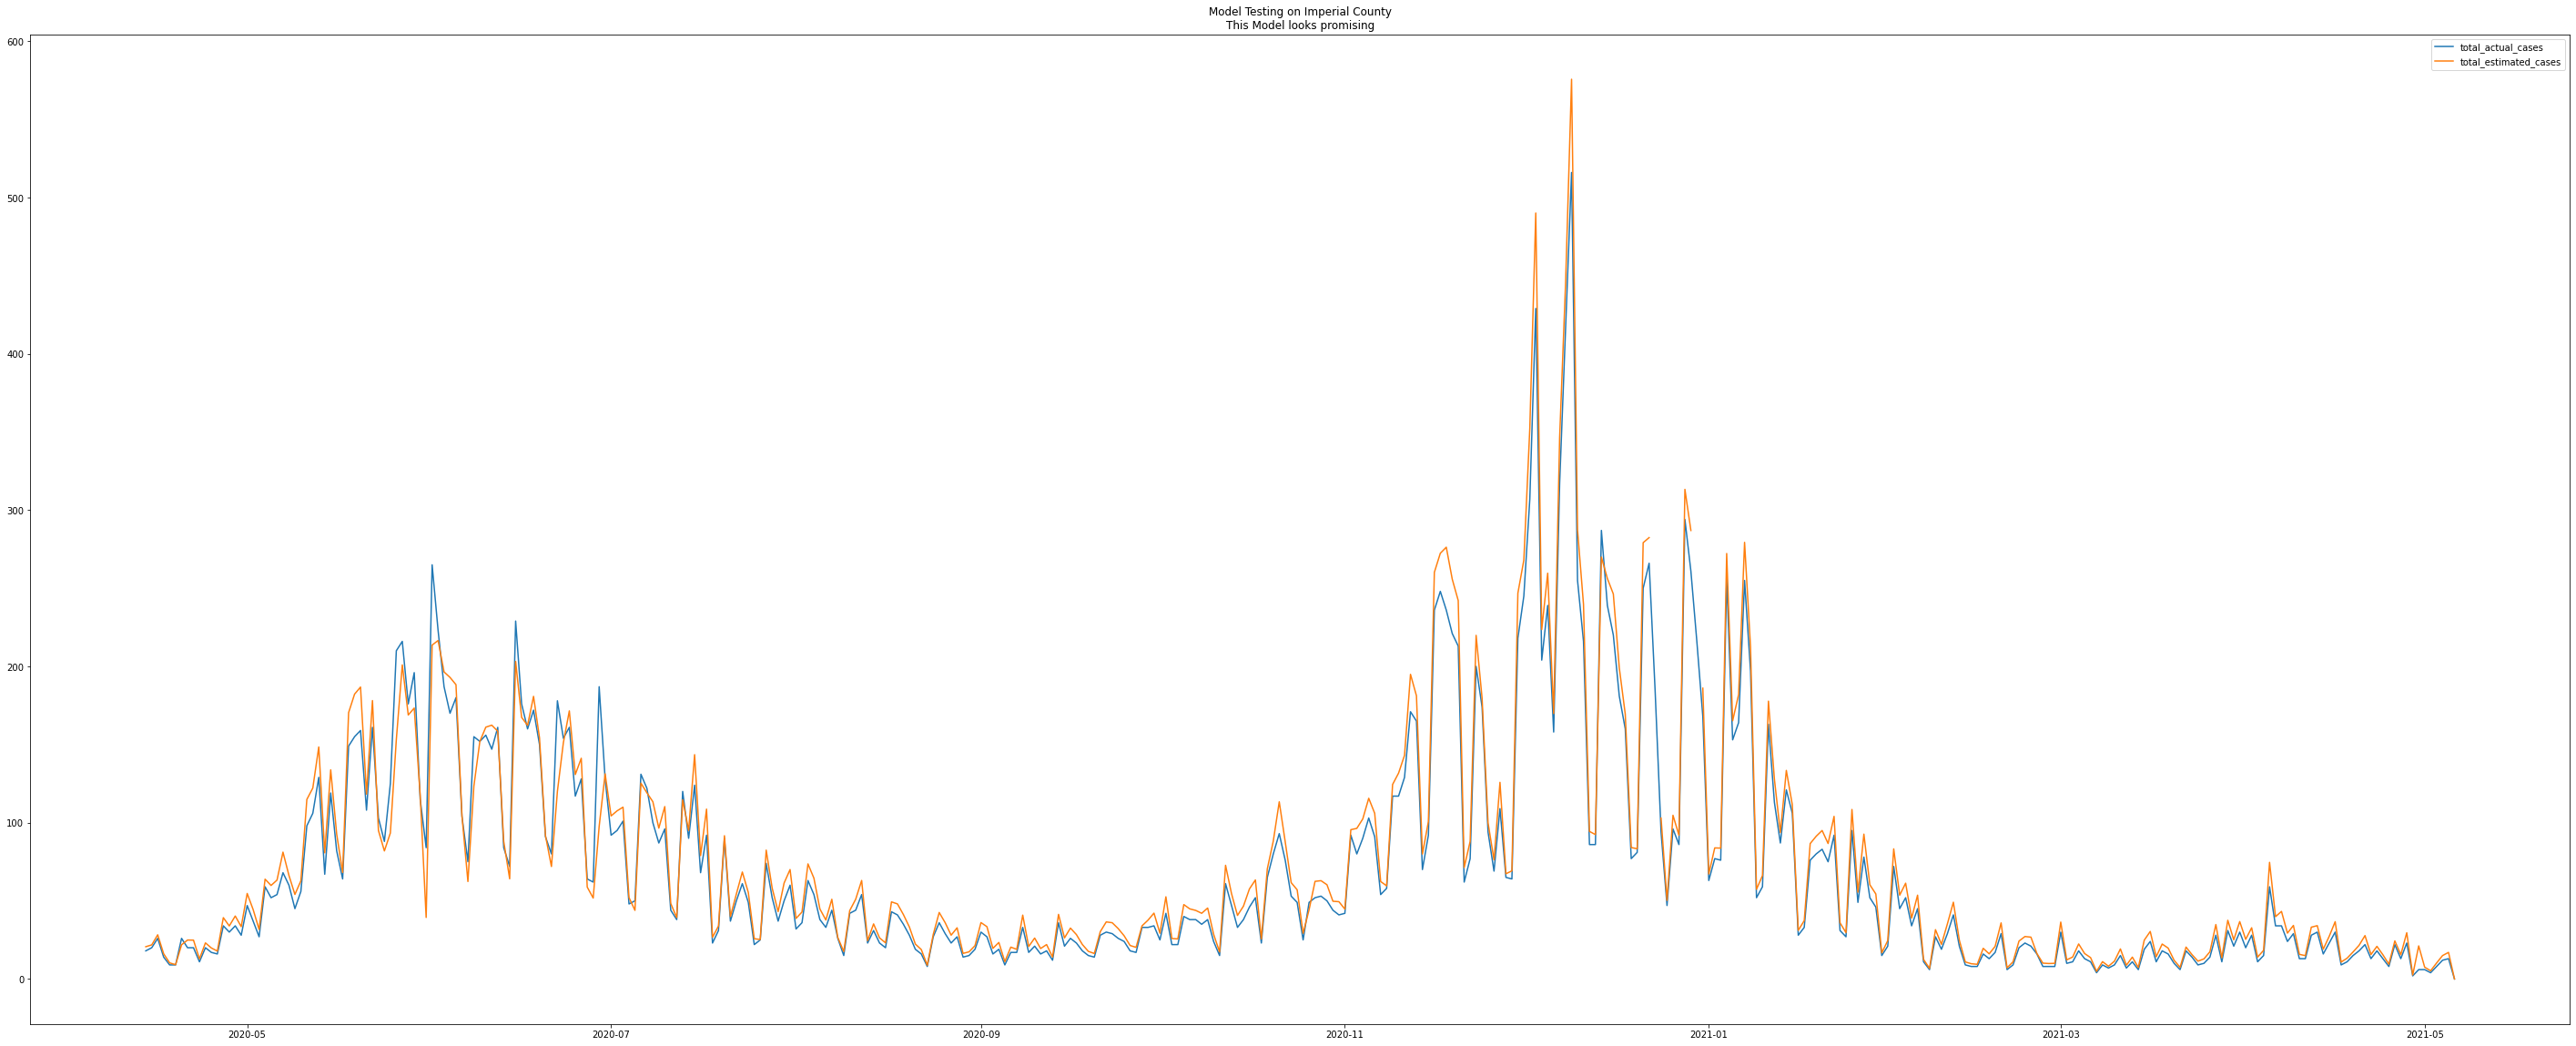

In [15]:
loop_df = ca_covid_df[ca_covid_df['county'] == 'Imperial'].copy()
print(ca_race_df['race'].unique())

print(loop_df.columns[4:])
for race in ca_race_df['race'].unique():
    loop_df[race] =  ( (loop_df[race] / loop_df['population'])*loop_df['cases'] ) + ( ( (loop_df[race] / loop_df['population'])*loop_df['cases'] ) * ca_race_diff[race].values )
    #loop_df[race] =  ca_race_diff[race].values
dates = ca_race_df['date'].unique()

loop_df['est'] = loop_df['Latino'] + loop_df['White'] + loop_df['Asian'] + loop_df['Black'] + loop_df['Native'] + loop_df['Hawaiian'] + loop_df['Multiracial']  
     

print(loop_df)

fig,ax = plt.subplots()    

ax.plot(dates,loop_df['cases'],label='total_actual_cases')
ax.plot(dates,loop_df['est'],label='total_estimated_cases')
#ax.plot(dates,ca_total_df['cases'].rolling(5).mean()*race_percent,label='expected')

plt.title(f'Model Testing on Imperial County\nThis Model looks promising')

plt.legend(fontsize=10)
plt.show()

In [16]:
#//***********************************************************************************************************************
#//*** Build the Model for all Counties.
#//***********************************************************************************************************************
#//*** Model takes the daily cases, and estimates the racial cases based on the portion of the population.
#//*** Example: 100 cases and Latino is .55. Latinos would be assigned 55 cases.
#//***********************************************************************************************************************
#//*** The expected racial value is adjusted by the statewide racial percentage
#//*** Example: If Latinos comprised .25 of the total State Cases, The modeled Latino cases would be 68.75 (55 *.25)
#//***********************************************************************************************************************

#//*** Build a dataframe to hold the expected cases
ca_covid_est_case_df = ca_covid_df.copy()


#//*** Process each race
for race in ca_race_df['race'].unique():
    #ca_covid_est_case_df[race] =  ( (ca_covid_est_case_df[race] / ca_covid_est_case_df['population'])*ca_covid_est_case_df['cases'] ) + ( ( (ca_covid_est_case_df[race] / loop_df['population'])*ca_covid_est_case_df['cases'] ) * ca_race_diff[race].values )
    
    #//*** Build the racial population percentage for each county
    #//*** Racial Population / total Population = County racial portion
    ca_covid_est_case_df[race] = (ca_covid_est_case_df[race] / ca_covid_est_case_df['population']) 
    
    #//*** Build the Expected COVID cases based on population percentage
    #//*** Case_[race] columns. County COVID cases * Racial portion 
    ca_covid_est_case_df[f'case_{race}'] = ca_covid_est_case_df[race] * ca_covid_est_case_df['cases']
    

#//*** Build model Dataframe. This holds the adjusted cases
#//*** This workflow is awkward because I"m building it for each date. I can probably do this better by merging the ca_race_diff dataframe.
ca_model_cases_df = pd.DataFrame()

#//*** Process each Date 
for group in ca_covid_est_case_df.groupby('date'):
    loop_date = group[0]
    loop_df = group[1]
    
    #//*** Get the race differential values on the given date
    loop_race_diff = ca_race_diff[ ca_race_diff['date']==loop_date] 
    
    #//*** Process the race data for each racial attribute.
    #//*** Each loop processes a racial attribute and adds an adjusted_[race] value.
    for race in ca_race_df['race'].unique():
        #//*** Get the modifier that race on the given day
        race_modifier = loop_race_diff[race].values[0]
        
        #//*** expected value + (expected value * modifier)
        #//*** Modifier can be positive or negative.
        loop_df[f'adj_{race}'] =  loop_df[f'case_{race}'].values + (loop_df[f'case_{race}'].values * race_modifier) 
    
    #//*** Add the results into ca_model_cases_df. Awkward an inefficient.
    ca_model_cases_df = pd.concat([ ca_model_cases_df, loop_df ] ) 
    


print(ca_model_cases_df)

            date    county  cases  deaths  total_tests  population    Latino     White     Asian     Black    Native  Hawaiian  Multiracial  case_Native  case_Asian  case_Black  case_Latino  \
0     2020-04-14     Kings    4.0     0.0         49.0      152940  0.552596  0.313443  0.037838  0.063175  0.008834  0.002033     0.022081     0.035334    0.151353    0.252700     2.210383   
1     2020-04-14   Ventura   21.0     0.0        276.0      846006  0.432426  0.446834  0.074086  0.017866  0.002898  0.001794     0.024096     0.060865    1.555801    0.375192     9.080946   
2     2020-04-14  Tuolumne    0.0     0.0         24.0       54478  0.126767  0.797111  0.013106  0.018485  0.014923  0.002129     0.027479     0.000000    0.000000    0.000000     0.000000   
3     2020-04-14    Tulare   37.0     2.0        164.0      466195  0.656000  0.276612  0.032898  0.012306  0.006853  0.000980     0.014350     0.253574    1.217235    0.455322    24.272006   
4     2020-04-14   Trinity    0.0  

In [17]:
print(ca_race_diff)
print(ca_race_diff['Latino']-(ca_race_diff['Latino']*0.061724))

           date    Native     Asian     Black    Latino  Multiracial  Hawaiian     White
6524 2020-04-14  0.000000 -0.282822  0.098295  0.232160     0.004796  0.491396 -0.502769
6525 2020-04-15  0.000000 -0.436714  0.085820  0.154362    -0.217118  0.584139 -0.365269
6526 2020-04-16 -1.452775  0.113232  0.012849  0.188535    -0.020478  0.739678 -0.644770
6527 2020-04-17 -0.171950 -0.324071  0.056667  0.267495    -1.298639  0.615543 -0.646311
6528 2020-04-18 -3.071524 -0.268969  0.129474  0.312269    -0.996452  0.737638 -0.924254
...         ...       ...       ...       ...       ...          ...       ...       ...
6907 2021-05-02  0.055045 -0.996572  0.286045  0.428606     0.550903  0.232771 -0.511287
6908 2021-05-03 -0.058624 -1.425760  0.246397  0.426537    -0.189190  0.338831 -0.724114
6909 2021-05-04  0.390046 -0.716628  0.178001  0.352540     0.199500  0.552913 -0.518399
6910 2021-05-05  0.128366 -1.214410  0.175246  0.433484     0.428036  0.148141 -0.527761
6911 2021-05-06 -0.26

In [18]:
#//*** Build the estimated case values to check the model
#//*** Sum() each Adjusted Racial attribute.
#//*** The difference between the sum() value and the est value is the model error.

#//*** There is a lot of extra data here to help me double check the maths. Most of these columns will be removed.
ca_model_cases_df['est'] = ca_model_cases_df['adj_Native'] + ca_model_cases_df['adj_Asian'] + ca_model_cases_df['adj_Black'] + ca_model_cases_df['adj_Latino'] + ca_model_cases_df['adj_Multiracial'] + ca_model_cases_df['adj_Hawaiian'] + ca_model_cases_df['White'] 

print(ca_model_cases_df)

            date    county  cases  deaths  total_tests  population    Latino     White     Asian     Black    Native  Hawaiian  Multiracial  case_Native  case_Asian  case_Black  case_Latino  \
0     2020-04-14     Kings    4.0     0.0         49.0      152940  0.552596  0.313443  0.037838  0.063175  0.008834  0.002033     0.022081     0.035334    0.151353    0.252700     2.210383   
1     2020-04-14   Ventura   21.0     0.0        276.0      846006  0.432426  0.446834  0.074086  0.017866  0.002898  0.001794     0.024096     0.060865    1.555801    0.375192     9.080946   
2     2020-04-14  Tuolumne    0.0     0.0         24.0       54478  0.126767  0.797111  0.013106  0.018485  0.014923  0.002129     0.027479     0.000000    0.000000    0.000000     0.000000   
3     2020-04-14    Tulare   37.0     2.0        164.0      466195  0.656000  0.276612  0.032898  0.012306  0.006853  0.000980     0.014350     0.253574    1.217235    0.455322    24.272006   
4     2020-04-14   Trinity    0.0  

In [19]:
#//*** Build a list of counties ordered by total COVID prevalence (most Cases per 100k) 

#//*** Get the Statewide 100k value. 
#//*** Get total Case Count from orig_df, dvided by total population / 100000
state_100k = ca_covid_orig_df['cases'].sum()/(ca_covid_orig_df['population'].unique().sum()/100000)

county_list = ca_100k_df['county'].unique()

county_100k = []

#//*** Get a list of counties with population greater than 100,000
for county in county_list:
    if ca_100k_df[ca_100k_df['county']==county].iloc[0]['population'] > 1:
        county_100k.append(county)
case_totals = []

#//*** Get the total Cases for each county per 100k
for county in county_100k:
    case_totals.append(ca_100k_df[ca_100k_df['county']==county]['cases'].sum())

#//*** Build a series with the county name and the total per100k value for each county. Sort by the Prevalence value.
ts = pd.Series(index = county_100k, data=case_totals).sort_values(ascending=False)


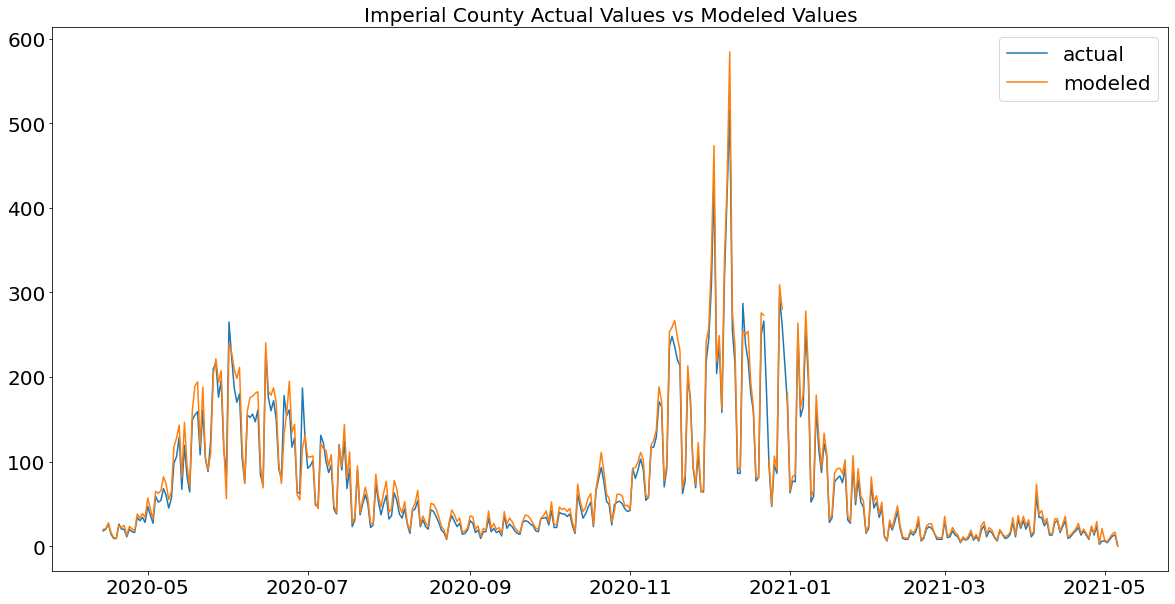

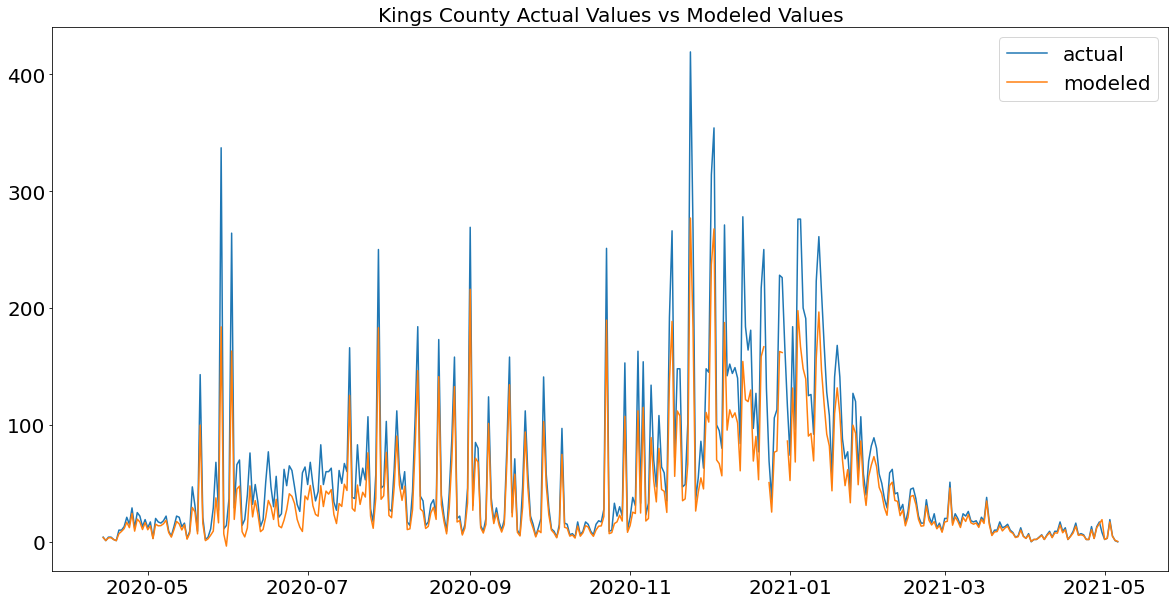

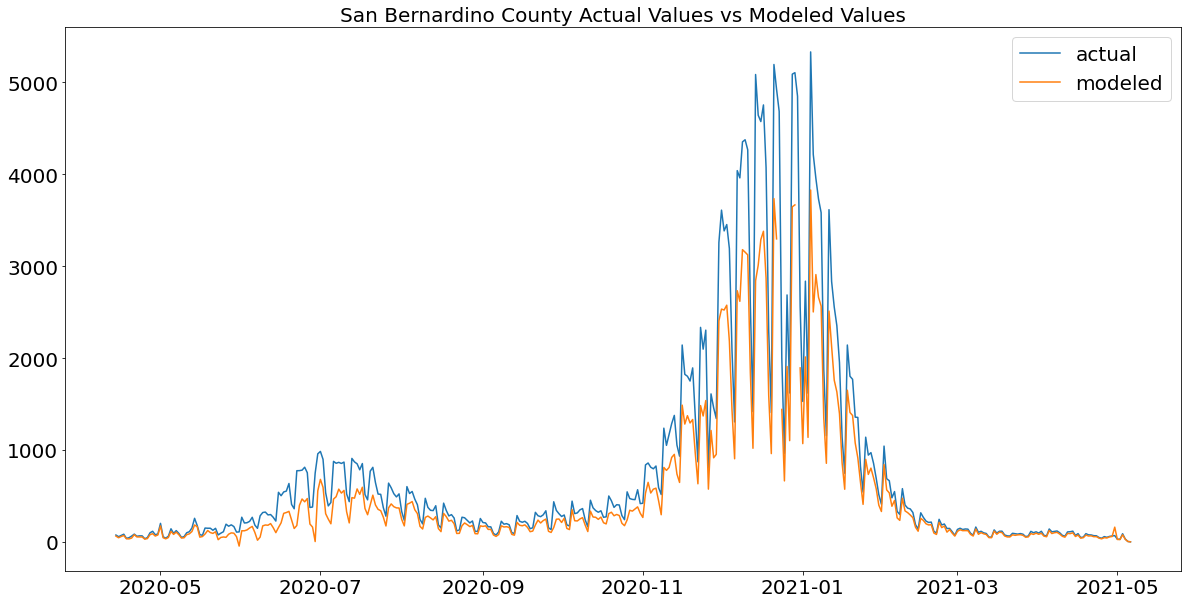

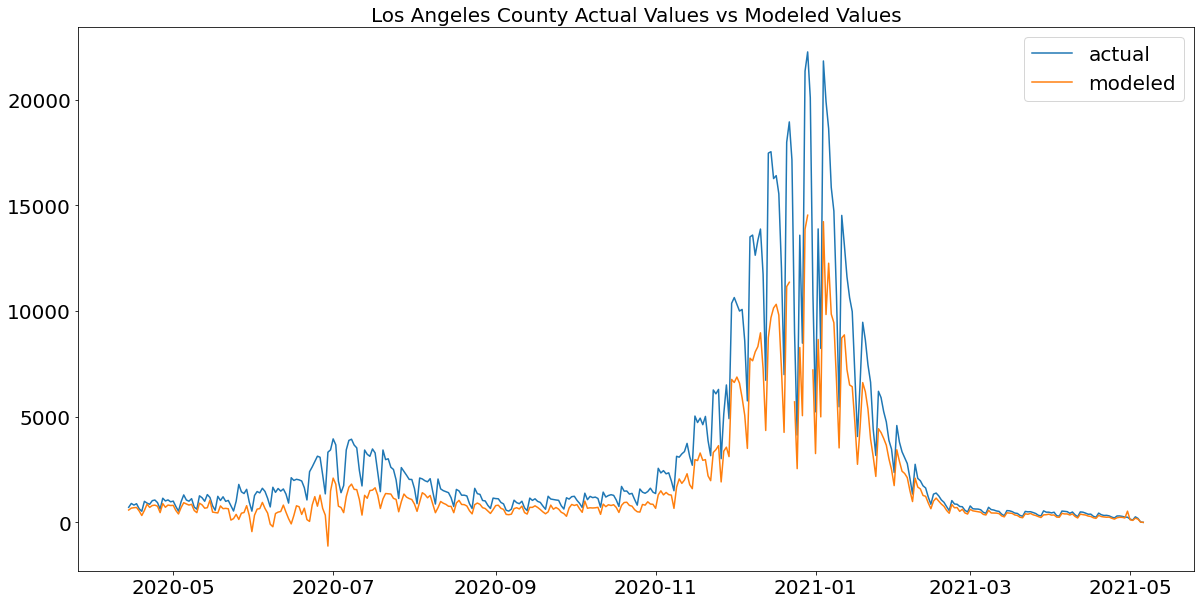

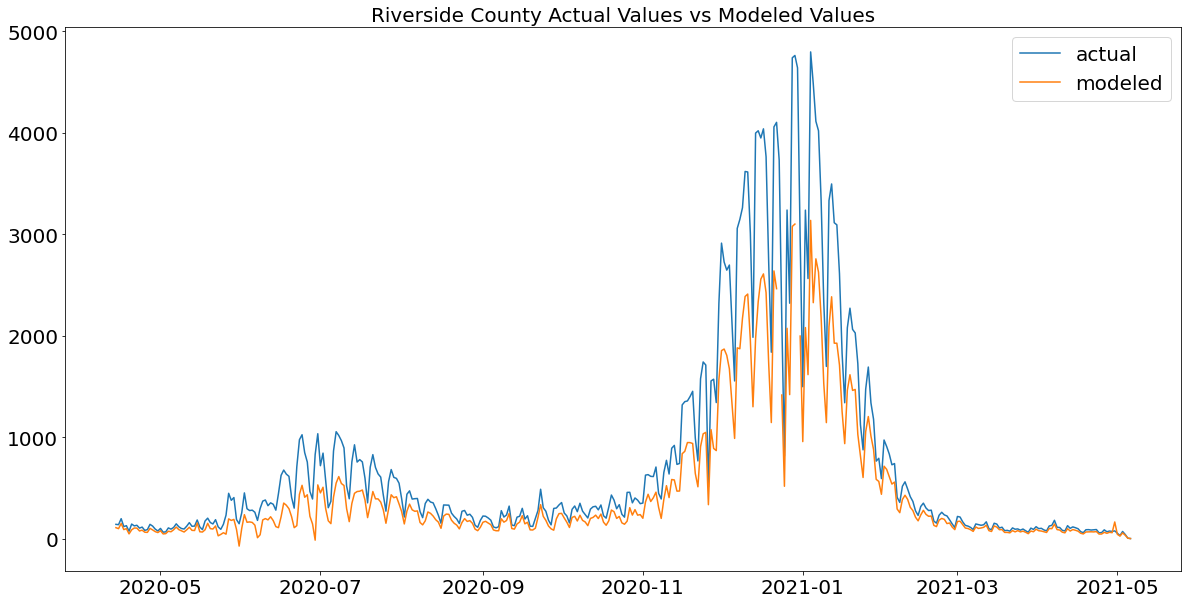

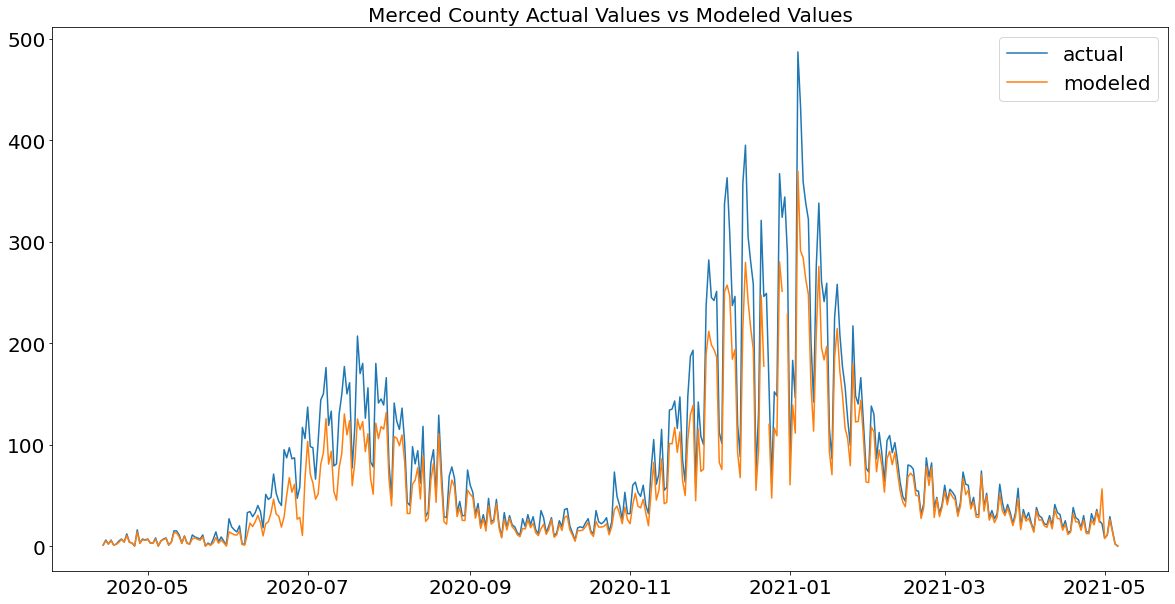

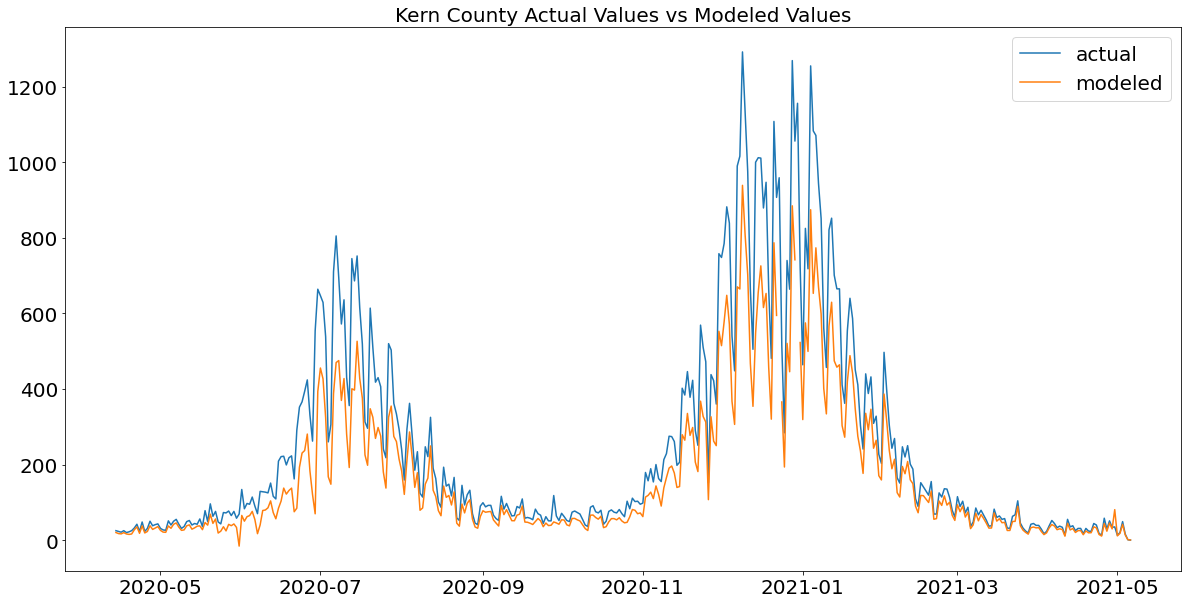

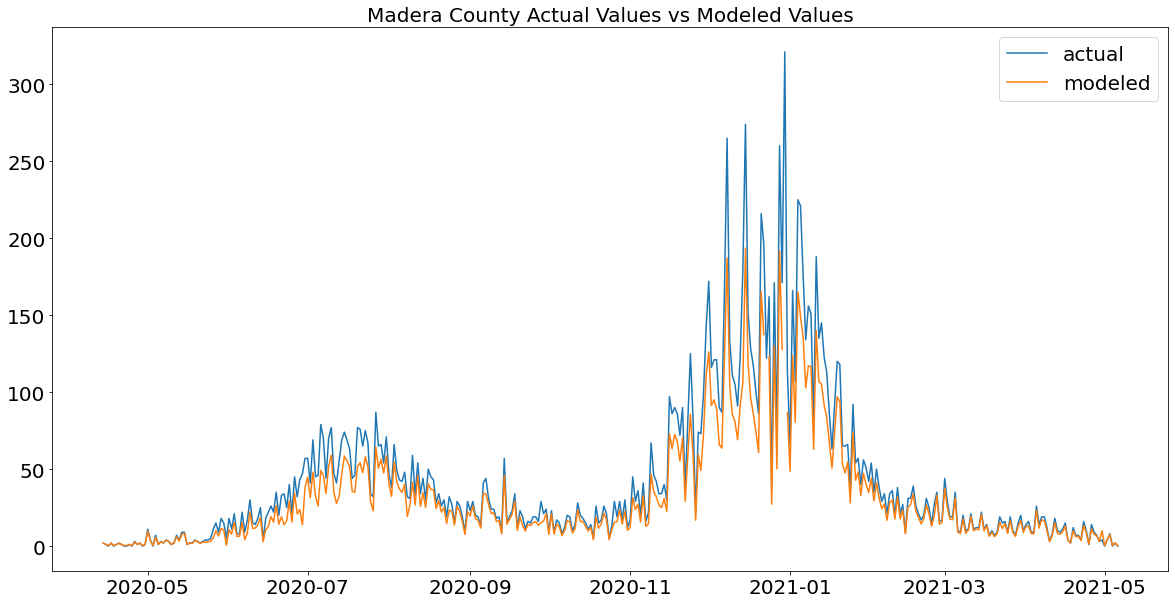

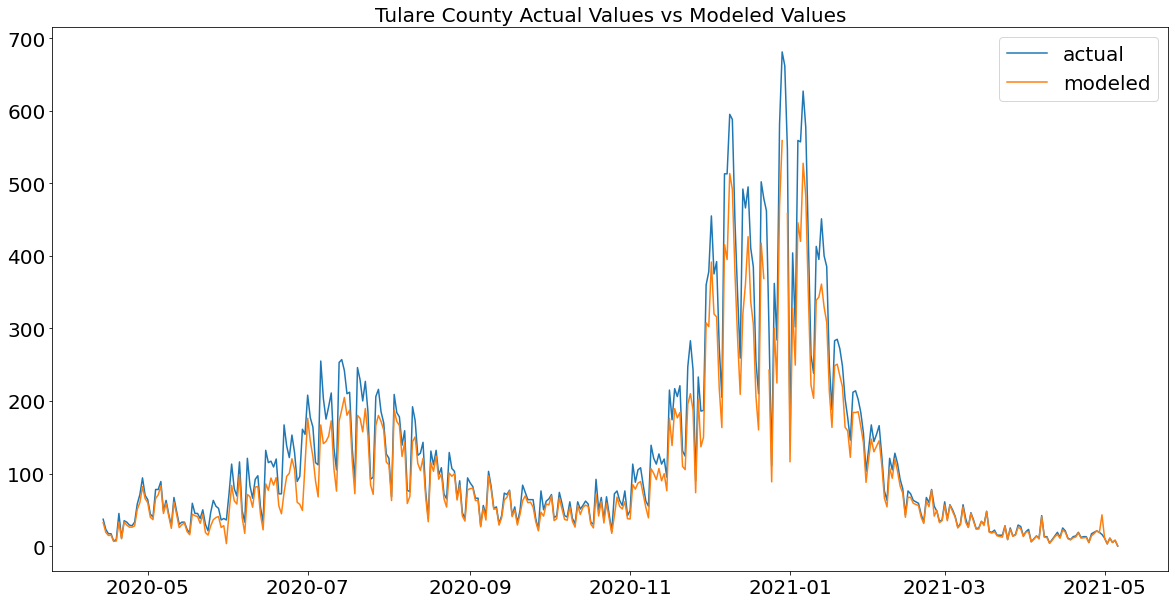

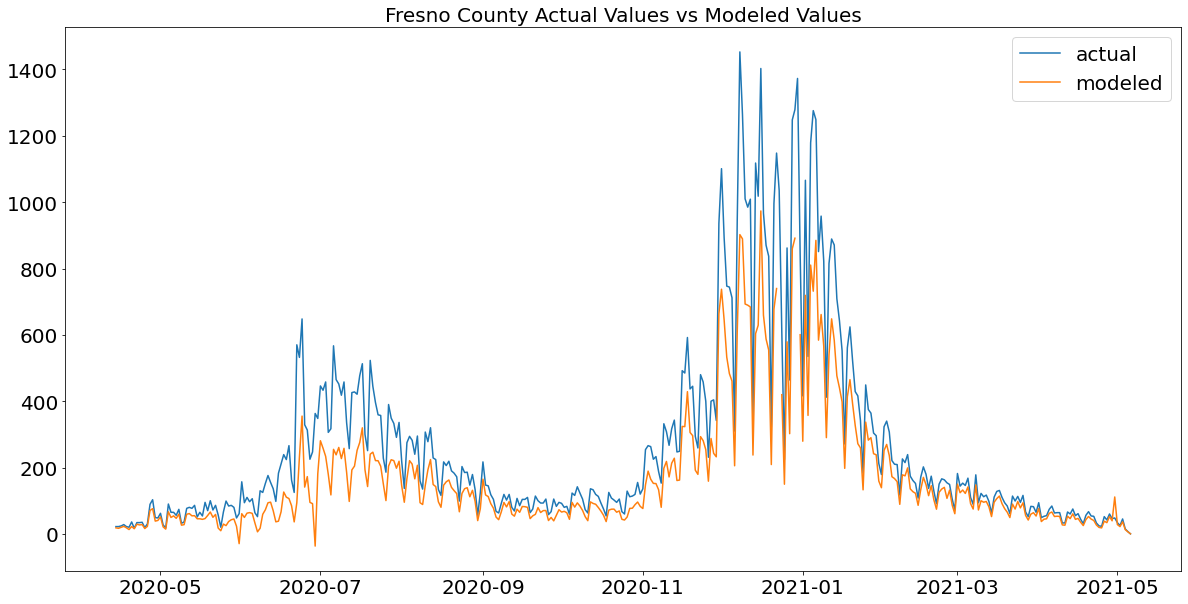

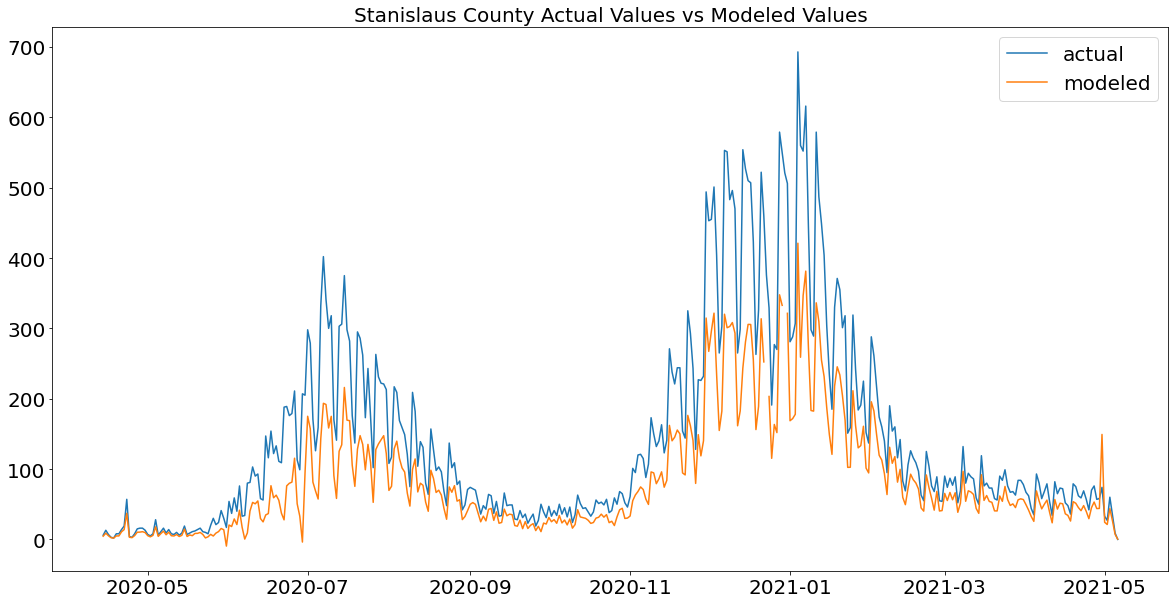

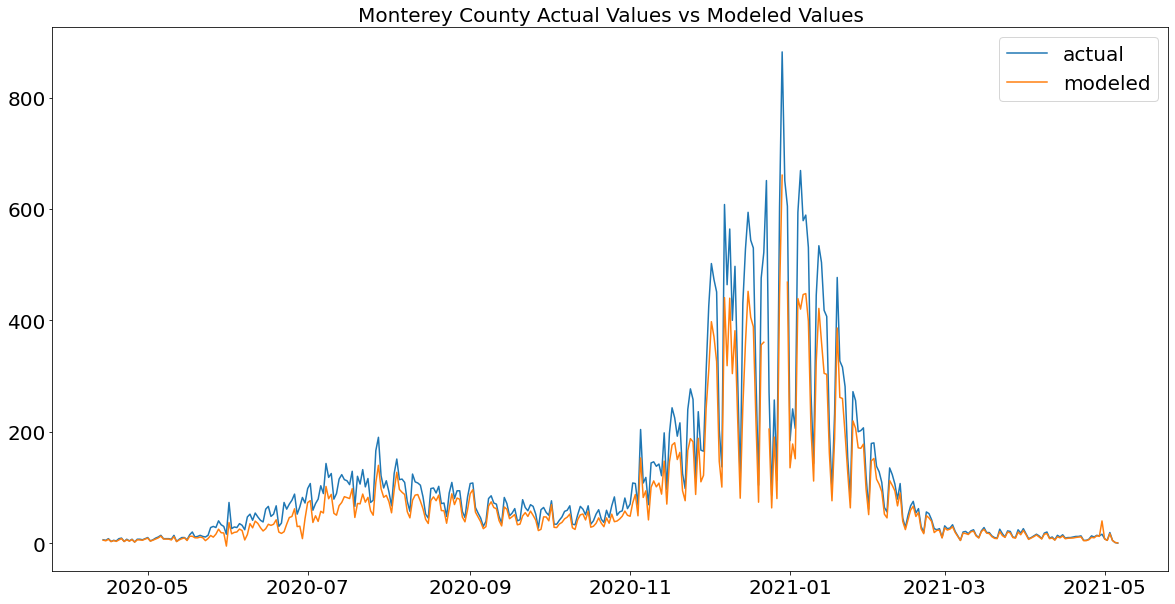

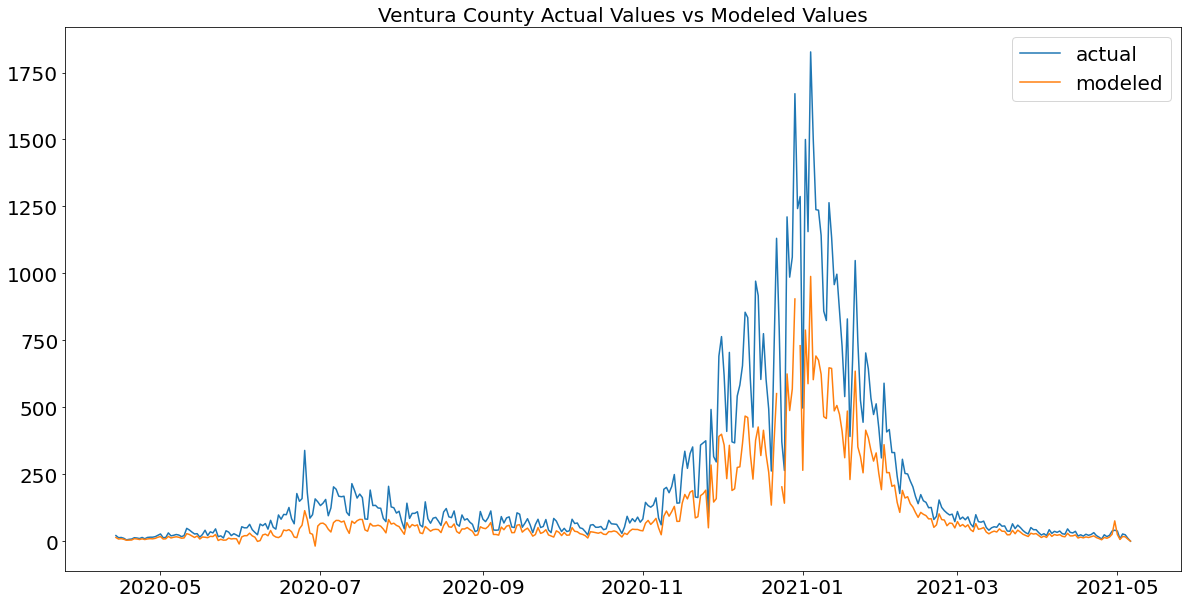

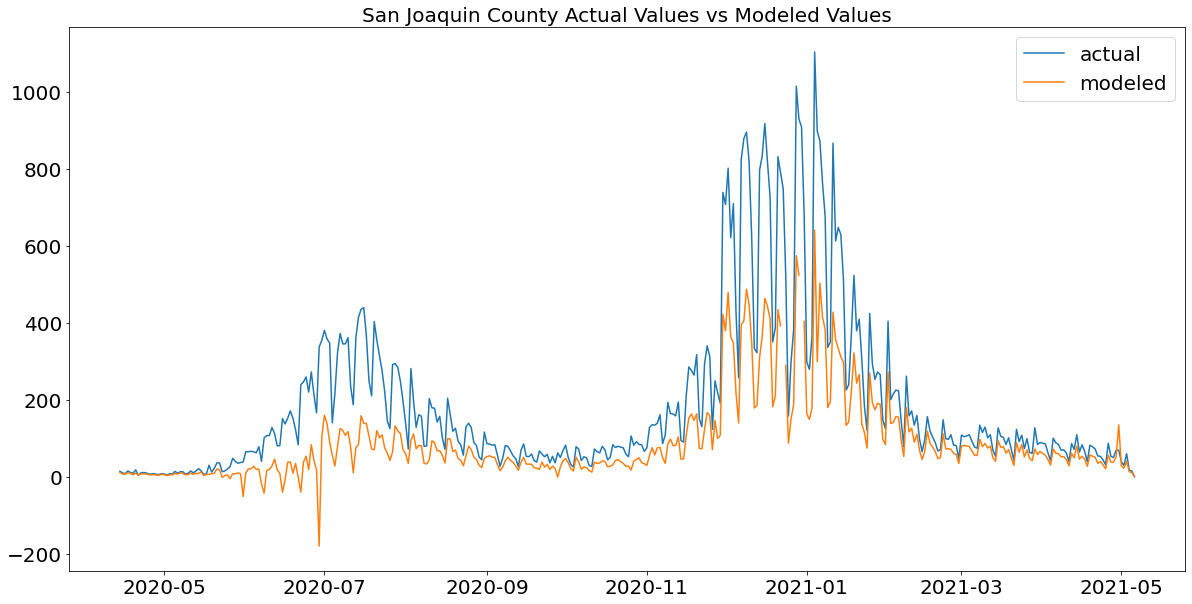

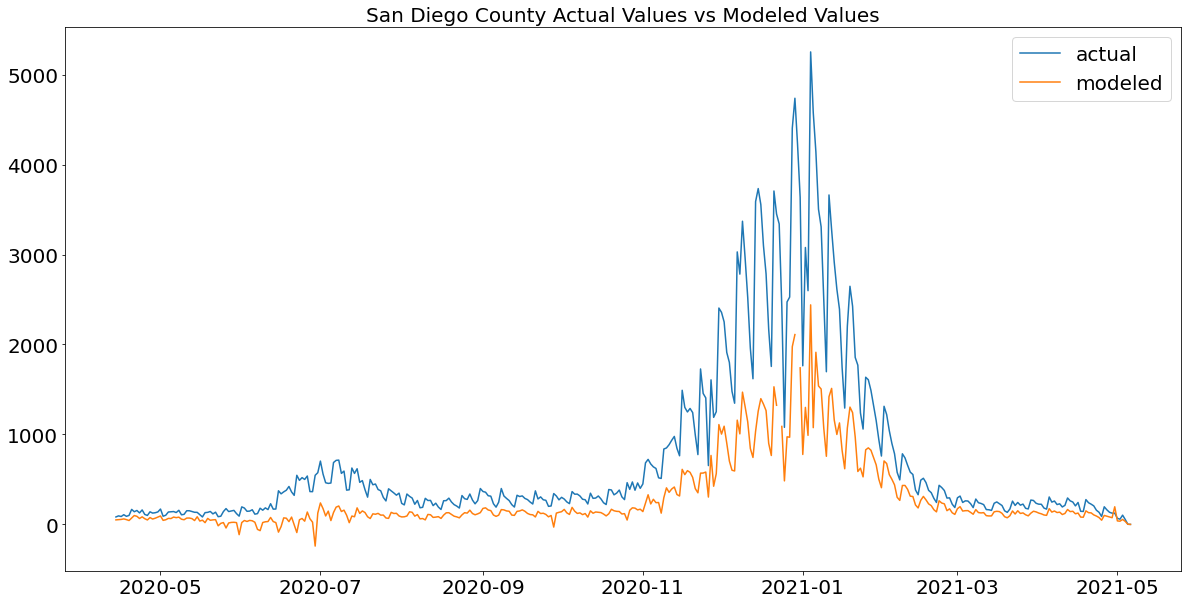

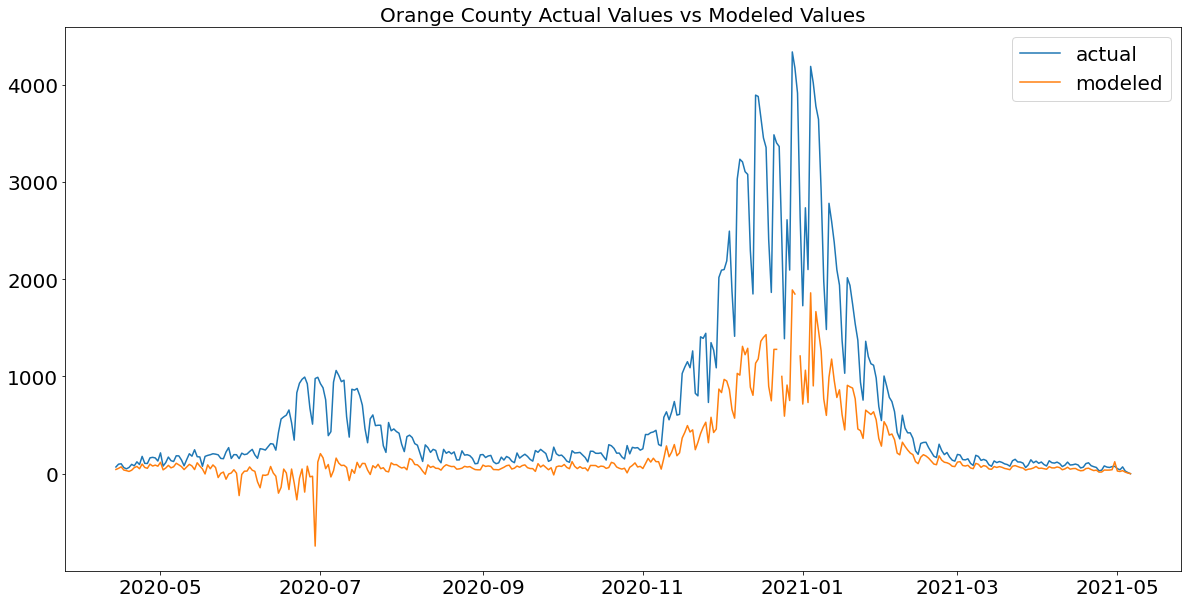

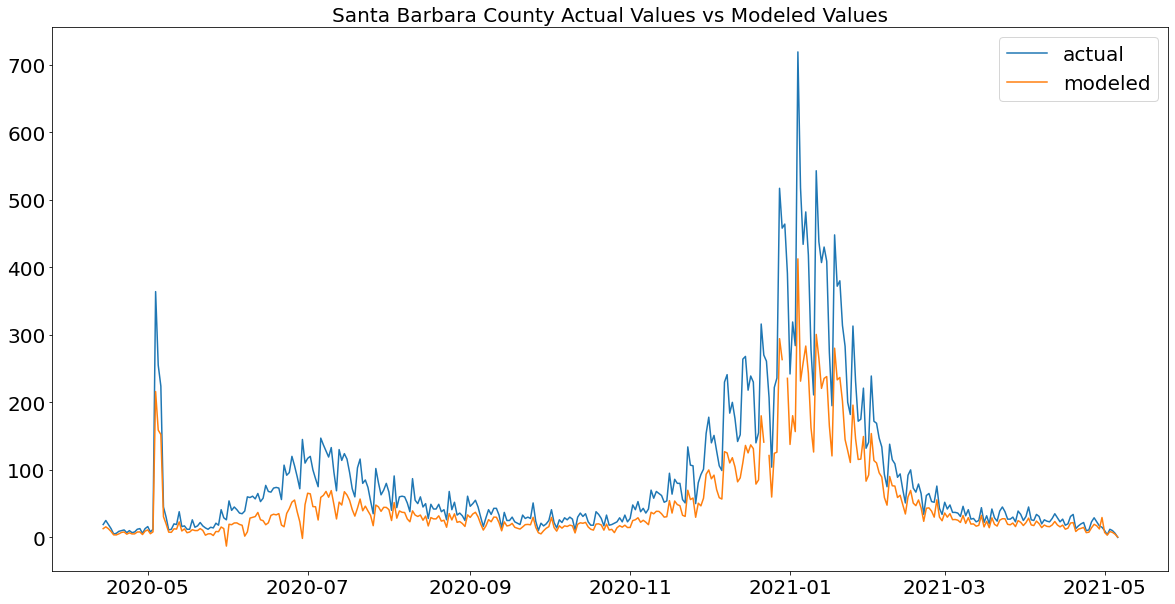

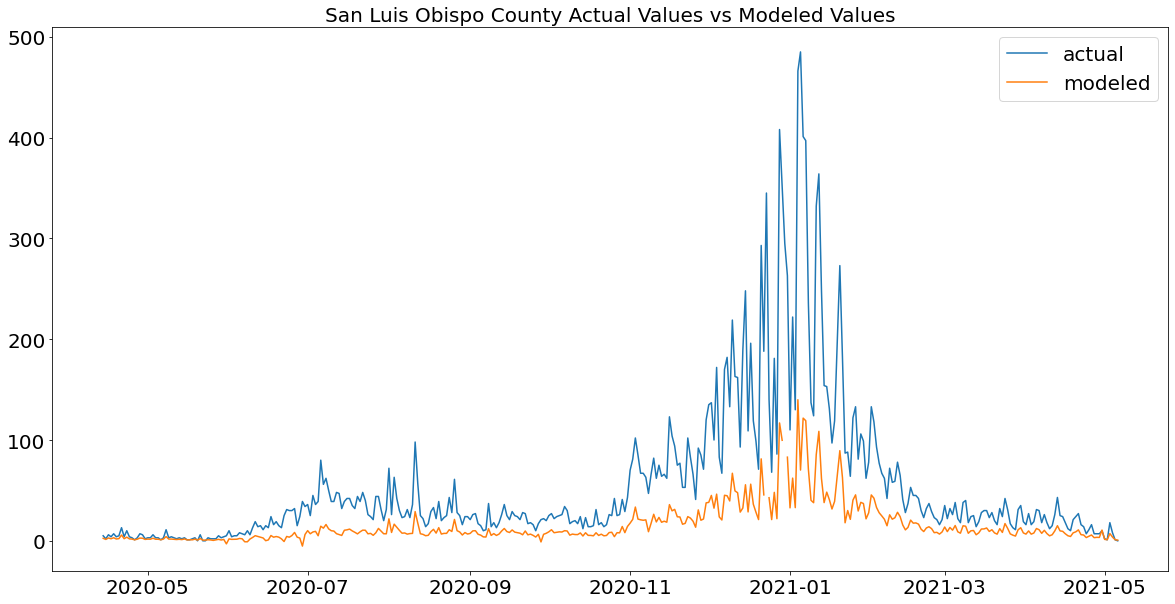

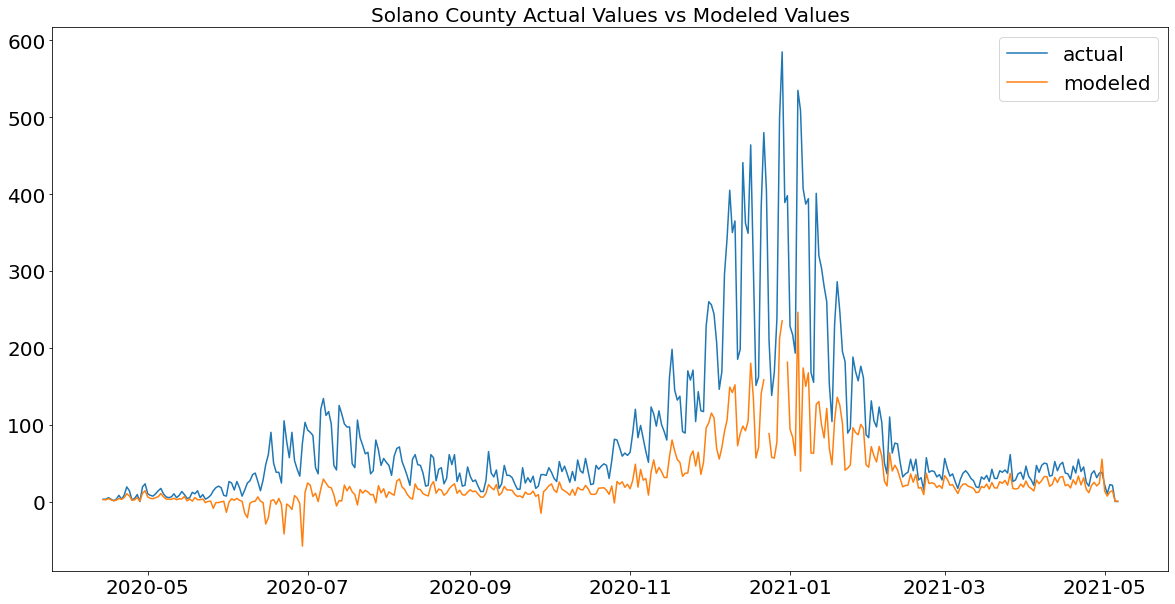

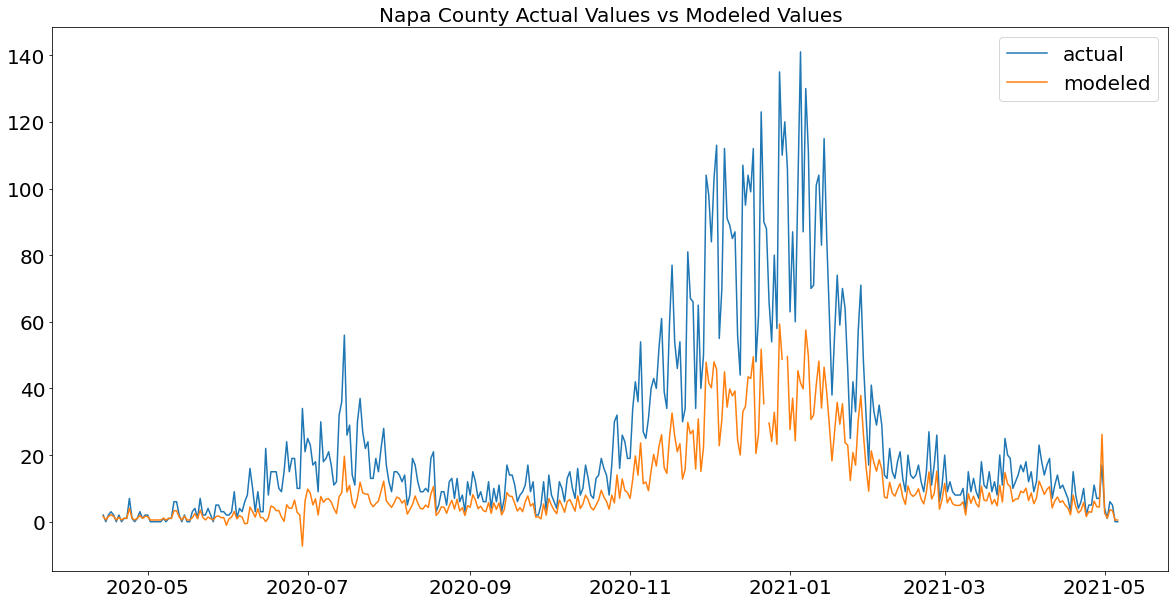

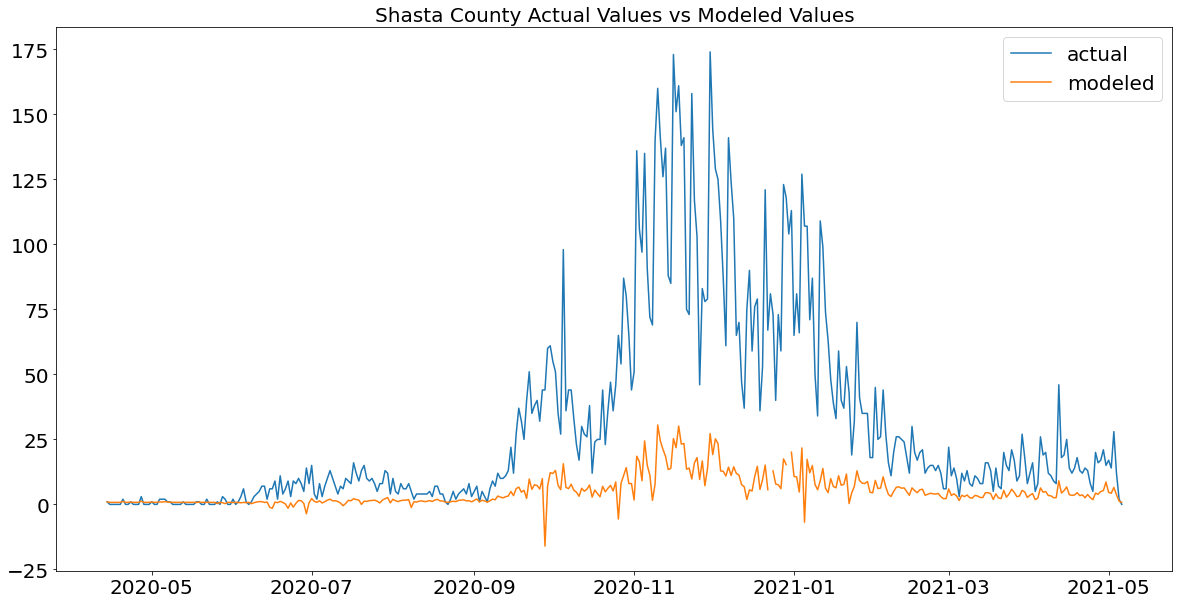

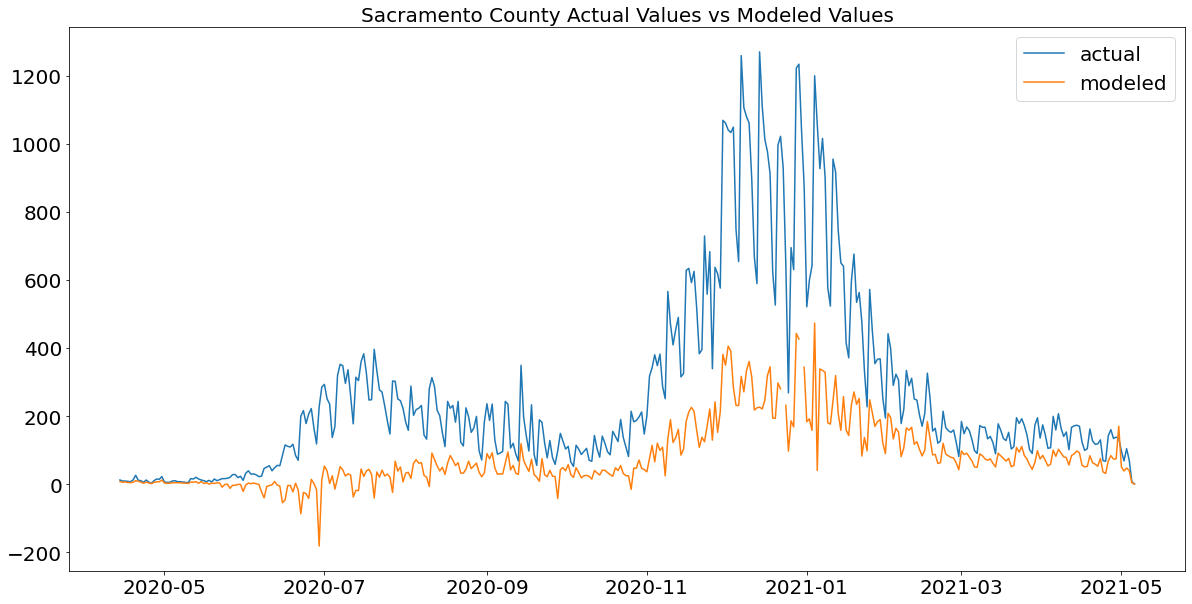

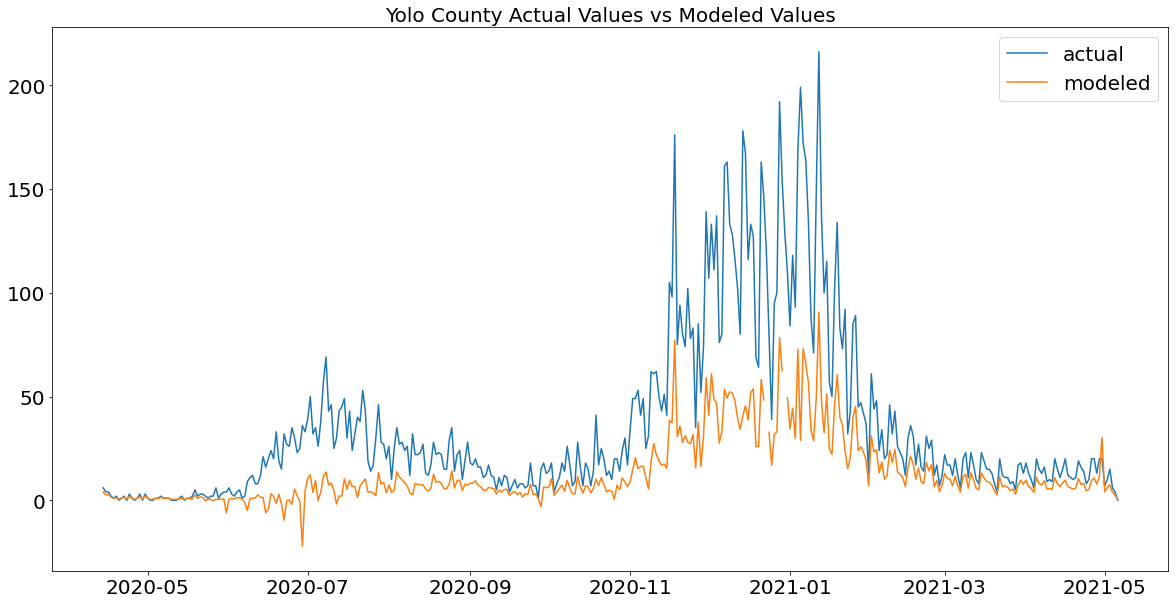

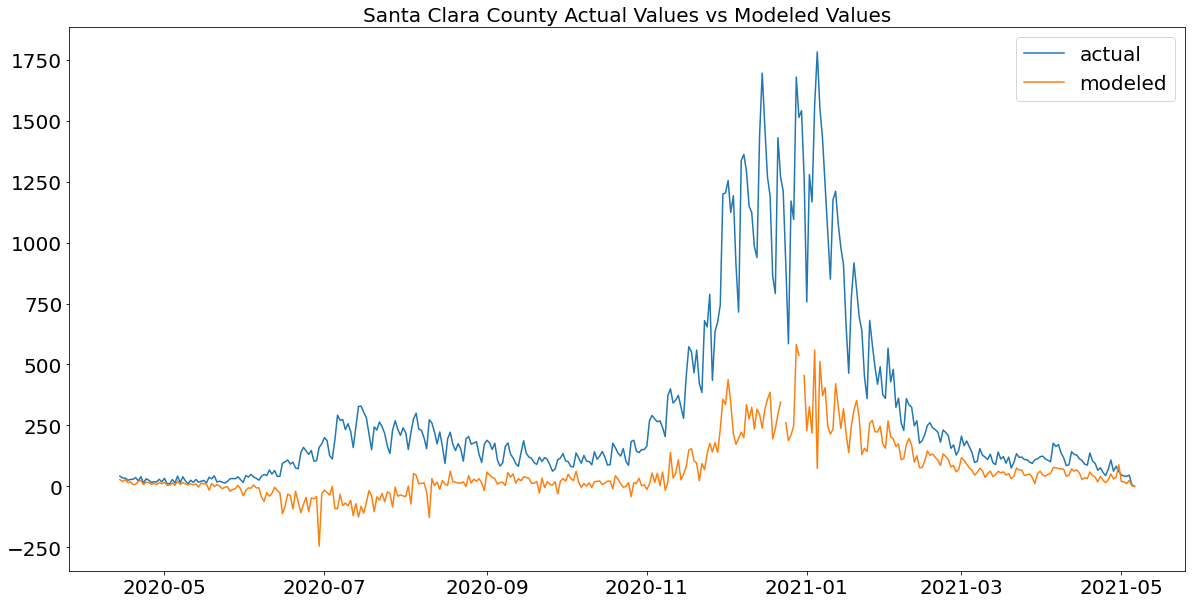

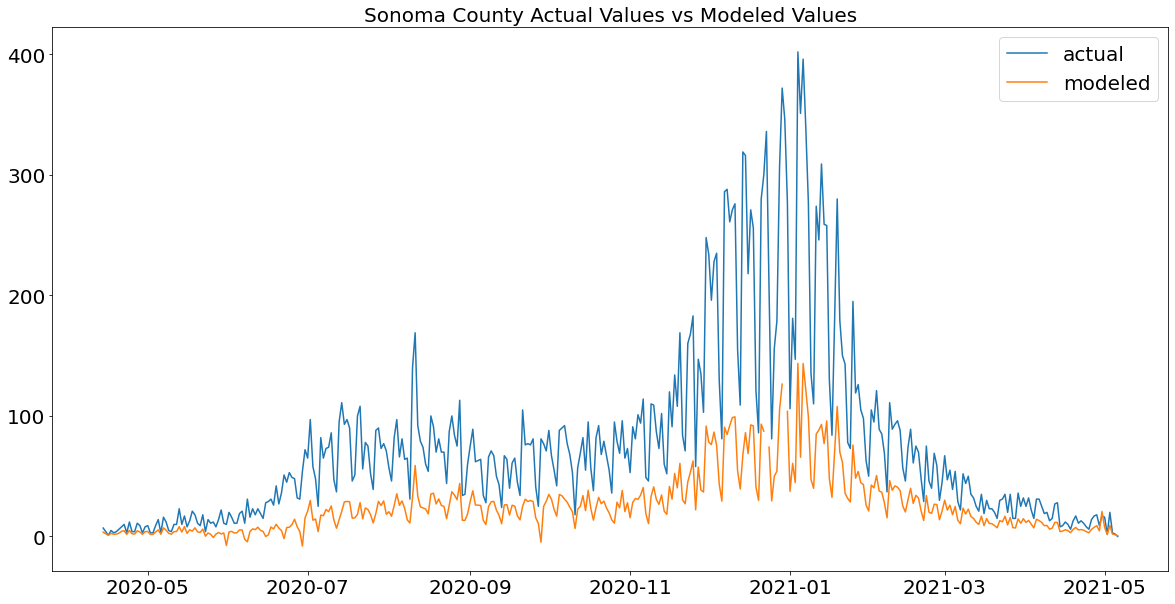

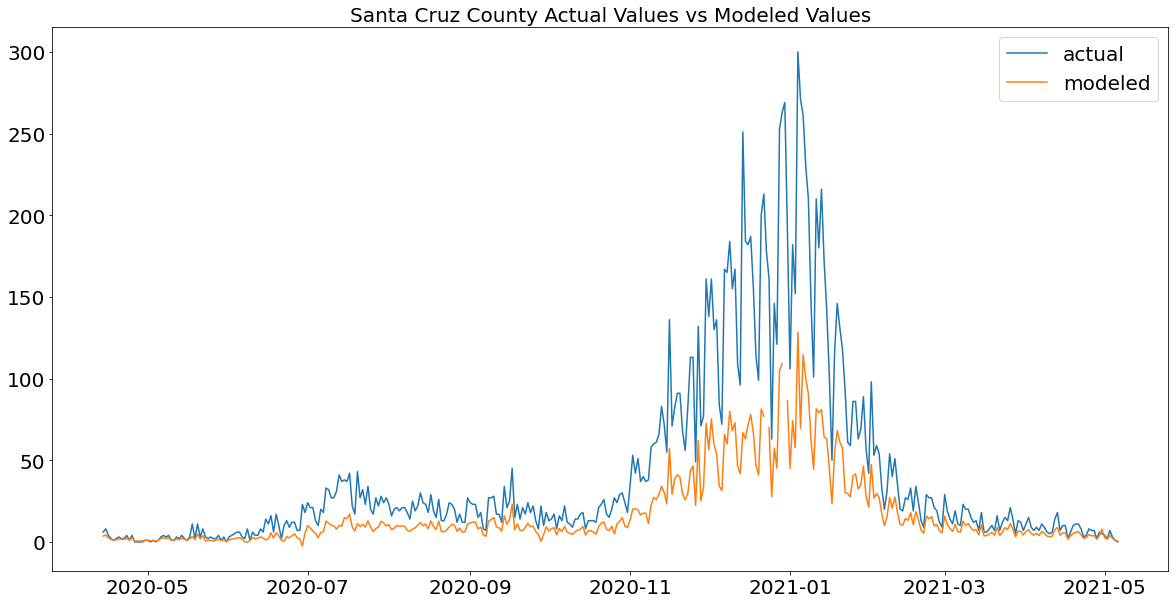

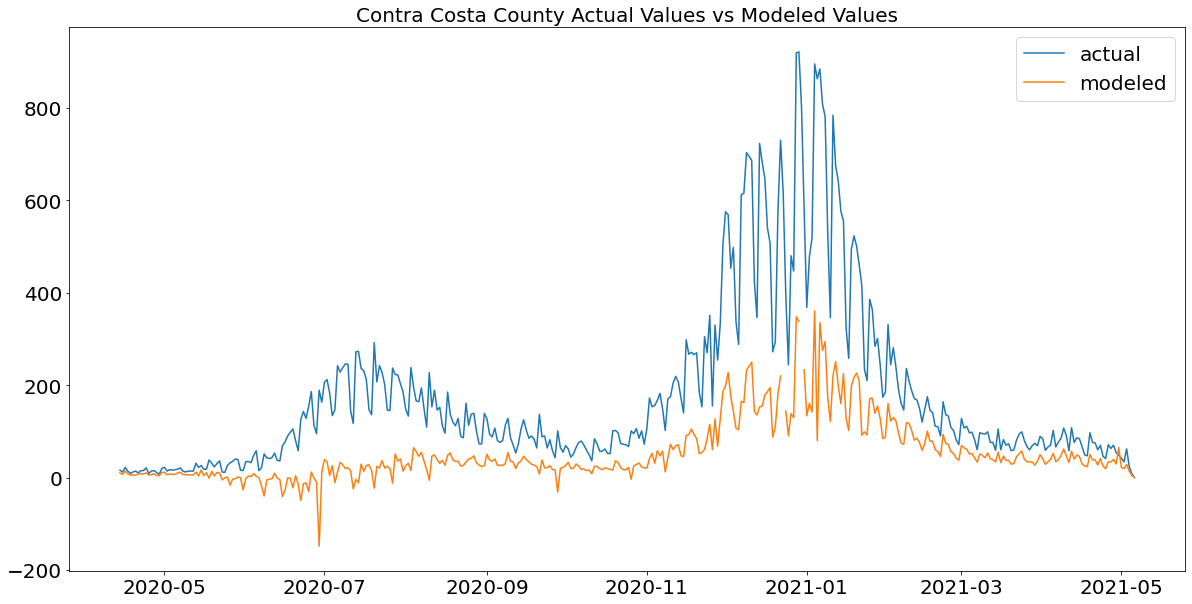

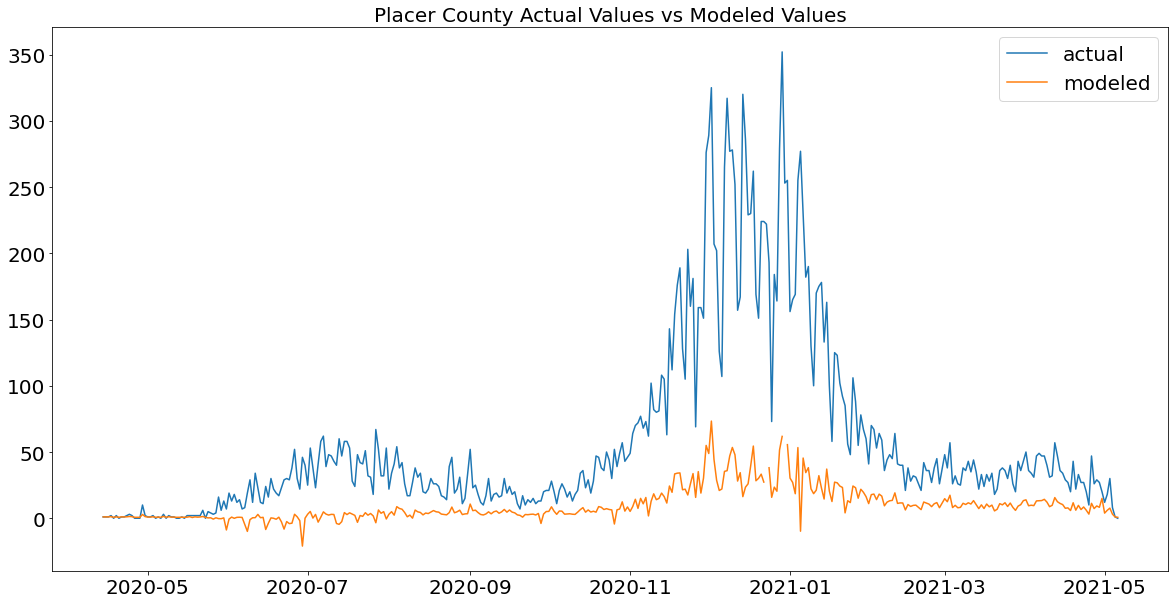

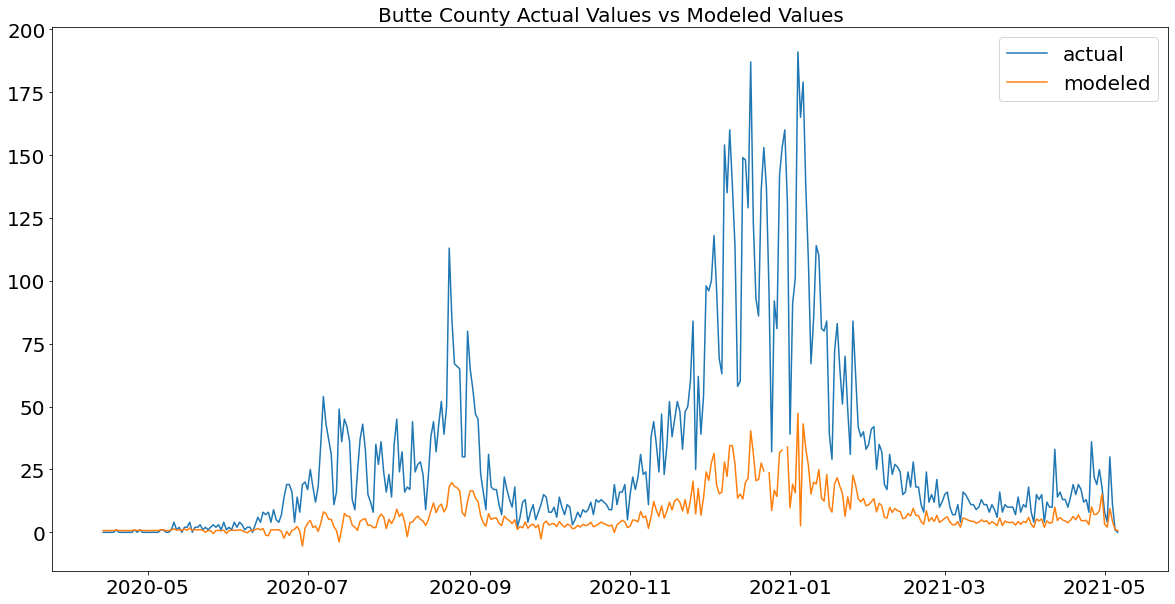

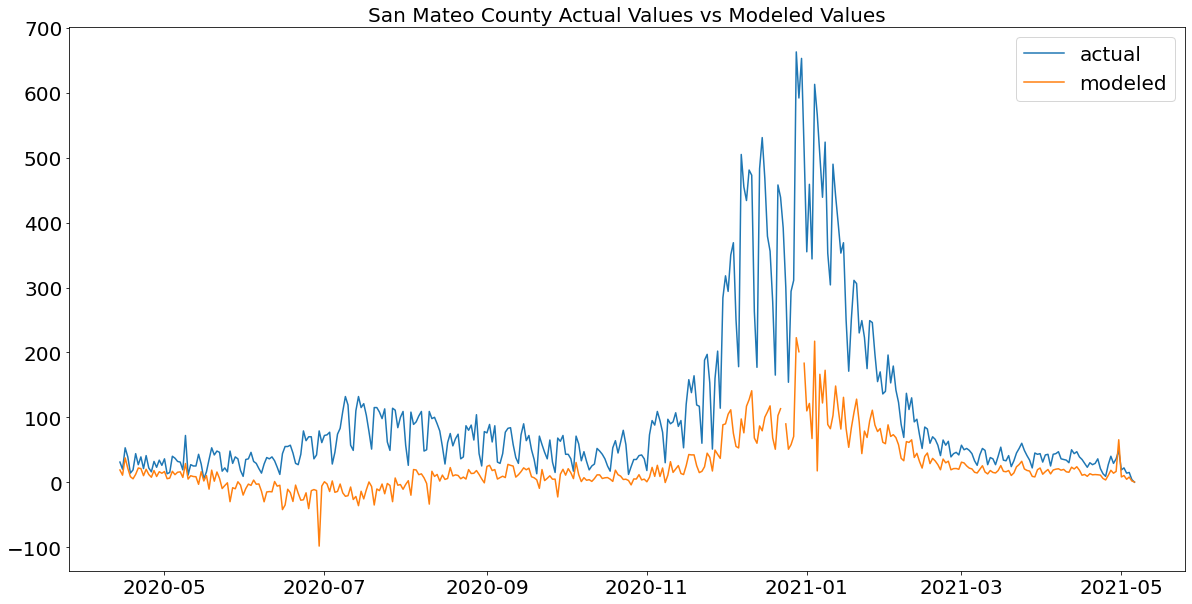

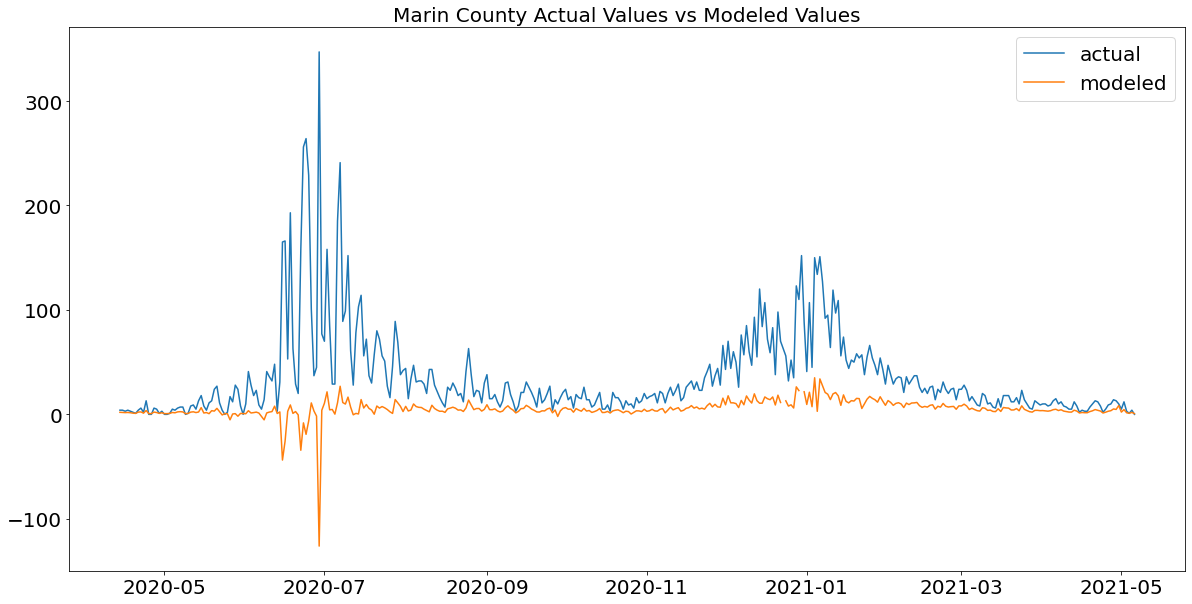

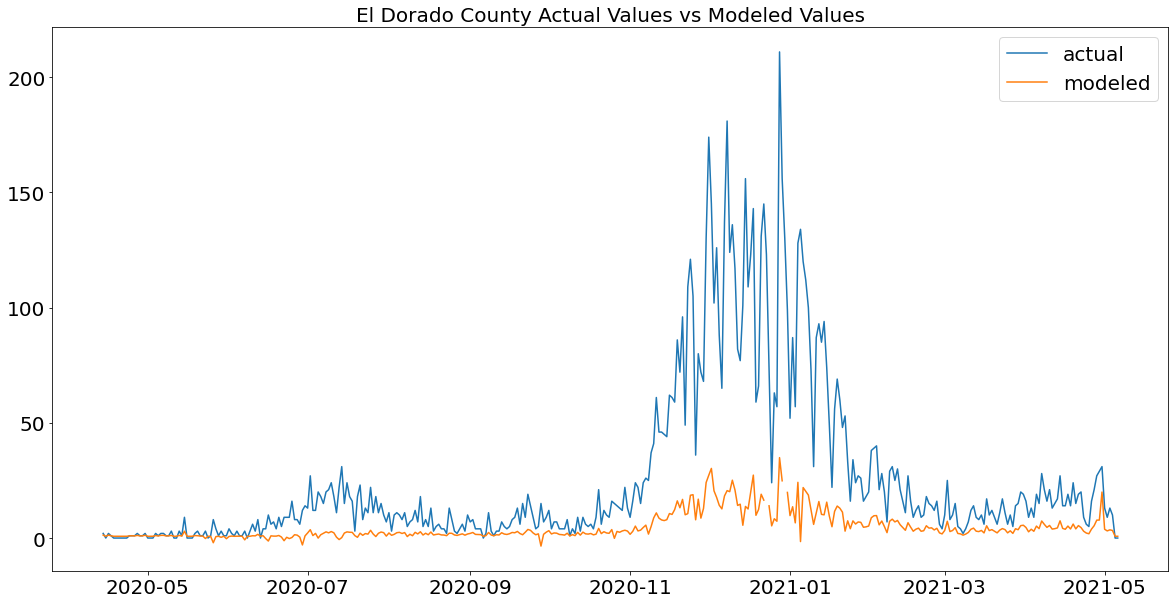

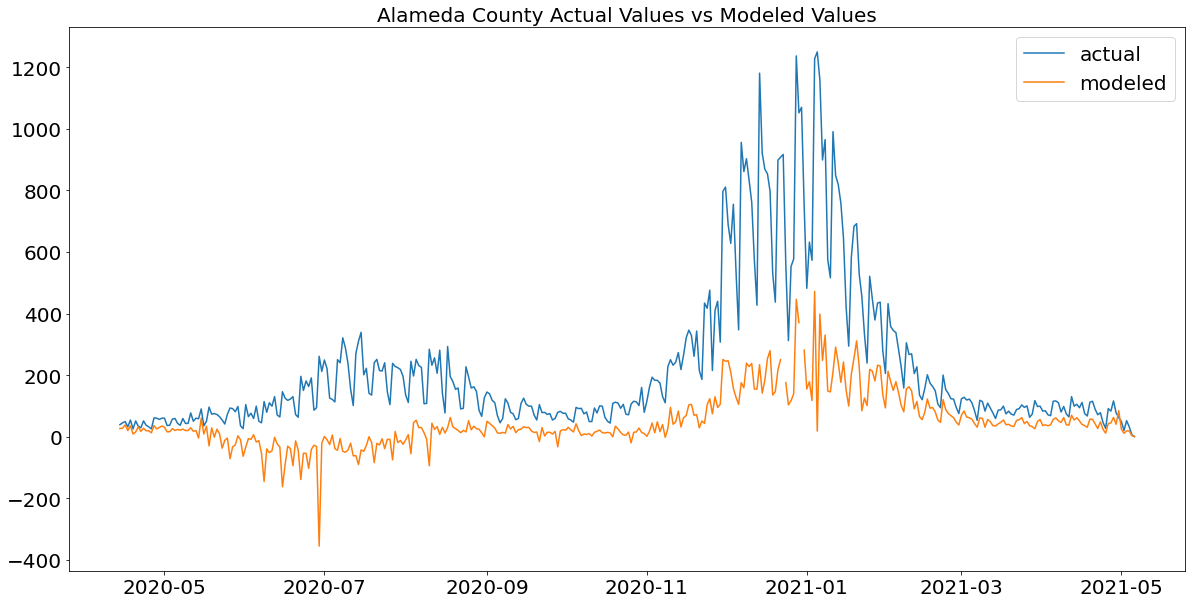

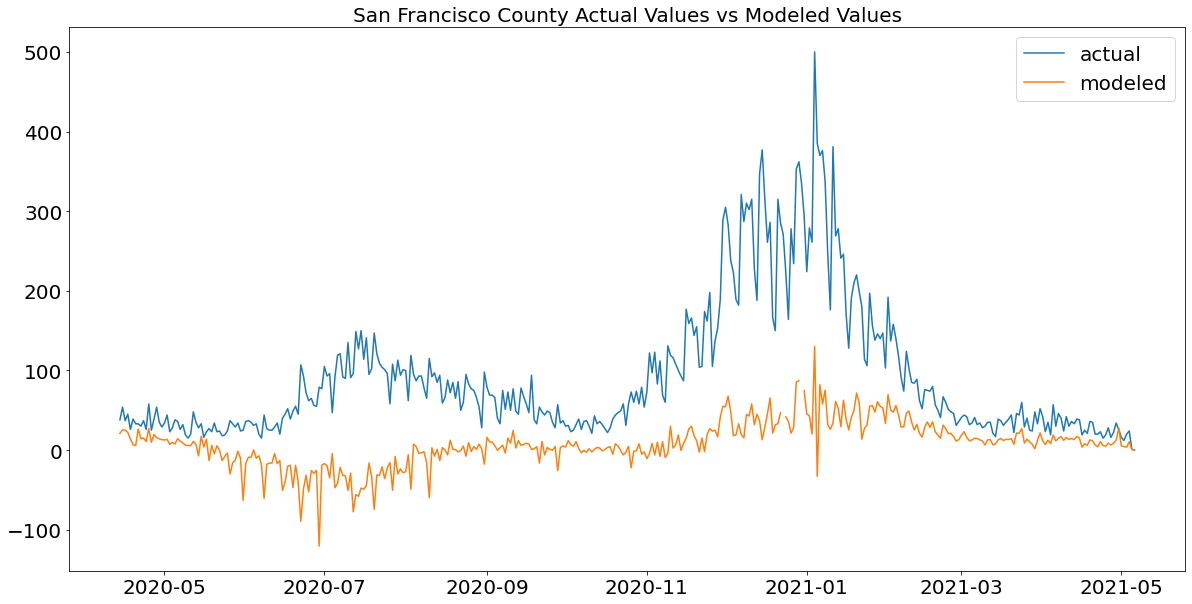

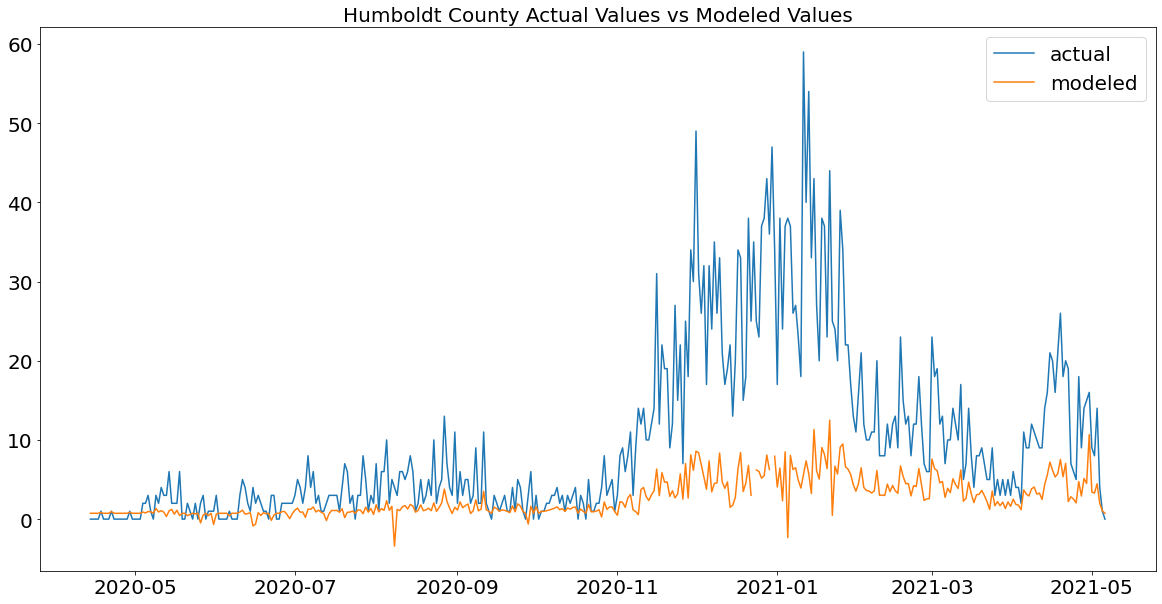

In [20]:
#//*** Display the actual values vs the modeled values.

dates = ca_model_cases_df['date'].unique()
counties = ts.index.values

plt.rcParams['figure.figsize'] = [20,10]
fontsize=20
for county in counties:
    
    
    
    loop_df = ca_model_cases_df[ ca_model_cases_df['county'] == county]
    
    if loop_df['population'].iloc[0] < 100000:
        continue
    
    fig,ax = plt.subplots()    

    ax.plot(dates,loop_df['cases'],label='actual')
    ax.plot(dates,loop_df['est'],label='modeled')
    
    plt.title(f'{county} County Actual Values vs Modeled Values', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.show()

In [21]:
#//***********************
#//*** Working Data Sets
#//****************************************
#//*** Statewide COVID cases by Ethnicity
#//****************************************
#print(ca_race_df)

ca_race_df['date'] = pd.to_datetime( ca_race_df['date'])
imperial_df = ca_covid_df[ca_covid_df['county'] == 'Imperial']
latino_df = ca_race_df[ca_race_df['race'] == 'Latino'].copy()


latino_df['cases'] = latino_df['cases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
latino_df['deaths'] = latino_df['deaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

latino_df.rename(columns={'cases':'state_latino_cases','deaths':'state_latino_deaths'},inplace=True)
#ca_race_df.rename( columns= {'report_date':'date'}, inplace=True)

imperial_df = pd.merge(imperial_df,latino_df,on='date')

del imperial_df['race']

imperial_df = imperial_df[1:]

print(imperial_df)
#print(latino_df)
"""
fig,ax = plt.subplots()
ax.plot(latino_df['date'],latino_df['new_cases'],label='cases')
ax.plot(latino_df['date'],latino_df['new_deaths'],label='deaths')
ax.plot(imperial_df['date'],imperial_df['cases'],label='deaths')
plt.legend()
plt.show()
"""
print()
#//*** Daily COVID Cases per 100k population
#print(ca_100k_df)

          date    county  cases  deaths  total_tests  population  Latino  White  Asian  Black  Native  Hawaiian  Multiracial  cum_cases  cum_deaths  state_latino_cases  state_latino_deaths  \
1   2020-04-15  Imperial   20.0     0.0         82.0      181215  154088  18161   2134   4386    1326       122          998       6433         226              -111.0               -111.0   
2   2020-04-16  Imperial   26.0     0.0        118.0      181215  154088  18161   2134   4386    1326       122          998       7013         254                57.0                 57.0   
3   2020-04-17  Imperial   14.0     1.0         32.0      181215  154088  18161   2134   4386    1326       122          998       7627         281                34.0                 34.0   
4   2020-04-18  Imperial    9.0     0.0         26.0      181215  154088  18161   2134   4386    1326       122          998       8195         314               -46.0                -46.0   
5   2020-04-19  Imperial    9.0     1.0 

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import KFold
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import MinMaxScaler
#from tensorflow.python.keras.models import Sequential
#from tensorflow.python.keras.layers import Dense
#from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [23]:
#//*** Modeling
#//*** Predict total Statewide cases from County Cases. This gives a county COVID weight.
#//*** Predict total Racial Cases from county Cases. This gives a county racial weight. The difference between the total prediction
#//*** And the racial prediction whould be the racial case count for the county. May have to the regression in reverse with the county weights.

#//*** Assemble Each County cases_100k
x = []
for county in ca_100k_df['county'].unique():
    x.append(ca_100k_df[ca_100k_df['county']==county]['cases'].values)


x = np.array(x).reshape(-1,58)    
#//**** Predict Statewide Cases
y = ca_total_df['cases_100k']

print(len(x))
print(len(y))

model = LinearRegression().fit(x,y)

print(model.score(x,y))

models_df = pd.DataFrame()
models_df['county'] = ca_100k_df['county'].unique()
models_df['state_100k'] = model.coef_
print(models_df)
print(model.intercept_)

388
388
0.12104615117677586
             county  state_100k
0             Kings   -0.253184
1           Ventura    0.001916
2          Tuolumne    0.051135
3            Tulare    0.040369
4           Trinity    0.047531
5            Tehama    0.183191
6            Sutter   -0.115691
7        Stanislaus    0.031005
8            Sonoma    0.339402
9            Solano    0.042865
10         Siskiyou   -0.082610
11           Sierra   -0.296841
12           Nevada   -0.048909
13             Yolo    0.228825
14      Santa Clara   -0.300638
15           Plumas   -0.033679
16        Riverside   -0.085666
17       Sacramento    0.313182
18       San Benito   -0.014426
19   San Bernardino    0.150741
20       Santa Cruz   -0.028961
21    San Francisco    0.089708
22      San Joaquin   -0.155228
23  San Luis Obispo    0.306433
24        San Mateo   -0.241370
25    Santa Barbara   -0.262957
26        San Diego   -0.156306
27           Placer    0.048590
28           Orange    0.059202
29          

In [24]:
#//*** Generate total covid prevalence by county.
#//*** Sort by prevalence

#//*** Get the Statewide 100k value. 
#//*** Get total Case Count from orig_df, dvided by total population / 100000
state_100k = ca_covid_orig_df['cases'].sum()/(ca_covid_orig_df['population'].unique().sum()/100000)

county_list = ca_100k_df['county'].unique()

county_100k = []

for county in county_list:
    if ca_100k_df[ca_100k_df['county']==county].iloc[0]['population'] > 1:
        county_100k.append(county)
case_totals = []

for county in county_100k:
    case_totals.append(ca_100k_df[ca_100k_df['county']==county]['cases'].sum())

#//*** Temp Series
ts = pd.Series(index = county_100k, data=case_totals).sort_values(ascending=False)

counties = ts.index.values
print(counties)

['Imperial' 'Kings' 'San Bernardino' 'Los Angeles' 'Riverside' 'Merced'
 'Kern' 'Madera' 'Tulare' 'Fresno' 'Stanislaus' 'Monterey' 'Ventura'
 'San Joaquin' 'San Diego' 'Orange' 'Santa Barbara' 'San Luis Obispo'
 'Solano' 'Napa' 'Shasta' 'Sacramento' 'Yolo' 'Santa Clara' 'Sonoma'
 'Santa Cruz' 'Contra Costa' 'Placer' 'Butte' 'San Mateo' 'Marin'
 'El Dorado' 'Alameda' 'San Francisco' 'Humboldt']


In [25]:
#//*** Modeling
#//*** Predict total Statewide cases from County Cases. This gives a county COVID weight.
#//*** Predict total Racial Cases from county Cases. This gives a county racial weight. The difference between the total prediction
#//*** And the racial prediction whould be the racial case count for the county. May have to the regression in reverse with the county weights.
inter_dict = {}

#//*** Assemble Each County cases_100k
x = []
print(counties)
for county in counties:
    x.append(ca_100k_df[ca_100k_df['county']==county]['cases'].values)


x = np.array(x).reshape(-1,len(counties))    
#//**** Predict Statewide Cases
y = ca_total_df['cases_100k']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print(len(x))
print(len(y))

model = LinearRegression().fit(x_train,y_train)
lasso = Lasso().fit(x_train,y_train)
print(model.score(x_test,y_test))
print(lasso.score(x_test,y_test))
models_df = pd.DataFrame()
models_df['county'] = counties
models_df['state_100k'] = model.coef_
inter_dict['state'] = model.intercept_
#//*** Modeling
#//*** Predict total Statewide cases from County Cases. This gives a county COVID weight.
#//*** Predict total Racial Cases from county Cases. This gives a county racial weight. The difference between the total prediction
#//*** And the racial prediction whould be the racial case count for the county. May have to the regression in reverse with the county weights.
#//*** Assemble Each County cases_100k
#x = []
#for county in counties:
#    x.append(ca_100k_df[ca_100k_df['county']==county]['cases'].values)


x = np.array(x).reshape(-1,len(counties))    

for race in ca_race_df['race'].unique():
    
    #//**** Predict Statewide Cases
    y = ca_race_df[ ca_race_df['race'] == race ]['cases_100k']

    model = LinearRegression().fit(x,y)
    
    inter_dict[race] = model.intercept_
    
    #print(model.score(x,y))

    
    #print(pd.DataFrame([ca_100k_df['county'].unique(), model.coef_]).transpose())
    models_df[f"{race}_100k"] = model.coef_

#print(inter_dict)
#print(models_df.sort_values('state_100k',ascending=False))
#print(models_df)

['Imperial' 'Kings' 'San Bernardino' 'Los Angeles' 'Riverside' 'Merced'
 'Kern' 'Madera' 'Tulare' 'Fresno' 'Stanislaus' 'Monterey' 'Ventura'
 'San Joaquin' 'San Diego' 'Orange' 'Santa Barbara' 'San Luis Obispo'
 'Solano' 'Napa' 'Shasta' 'Sacramento' 'Yolo' 'Santa Clara' 'Sonoma'
 'Santa Cruz' 'Contra Costa' 'Placer' 'Butte' 'San Mateo' 'Marin'
 'El Dorado' 'Alameda' 'San Francisco' 'Humboldt']
388
388
-0.42536380312062905
-0.3480312192238504


In [26]:
#//*** Modeling
#//*** Predict total Statewide cases from County Cases. This gives a county COVID weight.
#//*** Predict total Racial Cases from county Cases. This gives a county racial weight. The difference between the total prediction
#//*** And the racial prediction whould be the racial case count for the county. May have to the regression in reverse with the county weights.

#//*** Assemble Each County cases_100k
x = []
for county in ca_covid_df['county'].unique():
    x.append(ca_covid_df[ca_covid_df['county']==county]['cases'][:-30].values)

x = np.array(x).reshape(-1,58)    
#//**** Predict Statewide Cases
y = ca_total_df['cases'][:-30]

#model = LinearRegression().fit(x,y,sample_weight=np.array(weights).reshape(-1,58))
model = LinearRegression().fit(x,y)
print(model.score(x,y))

print(model.intercept_)
print(pd.DataFrame([ca_covid_df['county'].unique(), model.coef_]).transpose())


0.1562982074591046
8705.56870021153
                  0         1
0             Kings   10.3373
1           Ventura  -45.4033
2          Tuolumne -0.961079
3            Tulare   20.6994
4           Trinity  -27.9967
5            Tehama   19.0129
6            Sutter   13.0764
7        Stanislaus   12.9182
8            Sonoma   23.2453
9            Solano  -18.7955
10         Siskiyou   8.42495
11           Sierra  -14.0367
12           Nevada  -9.35046
13             Yolo  -17.4336
14      Santa Clara  0.647005
15           Plumas   8.75653
16        Riverside   9.72611
17       Sacramento    1.2208
18       San Benito   20.1883
19   San Bernardino  -28.9455
20       Santa Cruz   16.6283
21    San Francisco   2.07261
22      San Joaquin   17.2381
23  San Luis Obispo  -22.2528
24        San Mateo  -27.2609
25    Santa Barbara   19.1518
26        San Diego   -14.317
27           Placer   4.14375
28           Orange  -8.96111
29           Shasta   28.7019
30             Napa   44.4821
31  

In [27]:
print(ca_race_df['cases'])
print(ca_covid_df['cases'])

3801      0.0
3802      0.0
3803      2.0
3804      4.0
3805      1.0
        ...  
7296    500.0
7297    491.0
7298    464.0
7299    659.0
7300    771.0
Name: cases, Length: 2716, dtype: float64
0         4.0
1        21.0
2         0.0
3        37.0
4         0.0
         ... 
22499     0.0
22500     0.0
22501     0.0
22502     0.0
22503     0.0
Name: cases, Length: 22504, dtype: float64


In [28]:
print(ca_100k_df)
print(ca_total_df)
print(ca_race_df)

print(ca_covid_df)

#//**** Predict Statewide Latino cases
#imperial_df = ca_100k_df[ca_100k_df['county'] == 'Imperial']
#print(len(ca_race_df[ca_race_df['race'] == 'Latino']['cases'].values.reshape(-1, 1)))
#print(len(ca_100k_df[ca_100k_df['county'] == 'Imperial']['cases'].values))
#print(ca_race_df[ca_race_df['race'] == 'Latino']['cases'])
#print(ca_100k_df[ca_100k_df['county'] == 'Imperial']['cases'])

            date    county     cases    deaths  total_tests  population   Latino    White    Asian    Black   Native  Hawaiian  Multiracial
0     2020-04-14     Kings  2.615405  0.000000    32.038708     1.52940  0.84514  0.47938  0.05787  0.09662  0.01351   0.00311      0.03377
1     2020-04-14   Ventura  2.482252  0.000000    32.623882     8.46006  3.65835  3.78024  0.62677  0.15115  0.02452   0.01518      0.20385
2     2020-04-14  Tuolumne  0.000000  0.000000    44.054481     0.54478  0.06906  0.43425  0.00714  0.01007  0.00813   0.00116      0.01497
3     2020-04-14    Tulare  7.936593  0.429005    35.178412     4.66195  3.05824  1.28955  0.15337  0.05737  0.03195   0.00457      0.06690
4     2020-04-14   Trinity  0.000000  0.000000     0.000000     0.12285  0.00907  0.10060  0.00173  0.00070  0.00502   0.00027      0.00546
...          ...       ...       ...       ...          ...         ...      ...      ...      ...      ...      ...       ...          ...
22499 2021-05-06    

0.12335451977213541
[0.26381611]
16.296628604533563


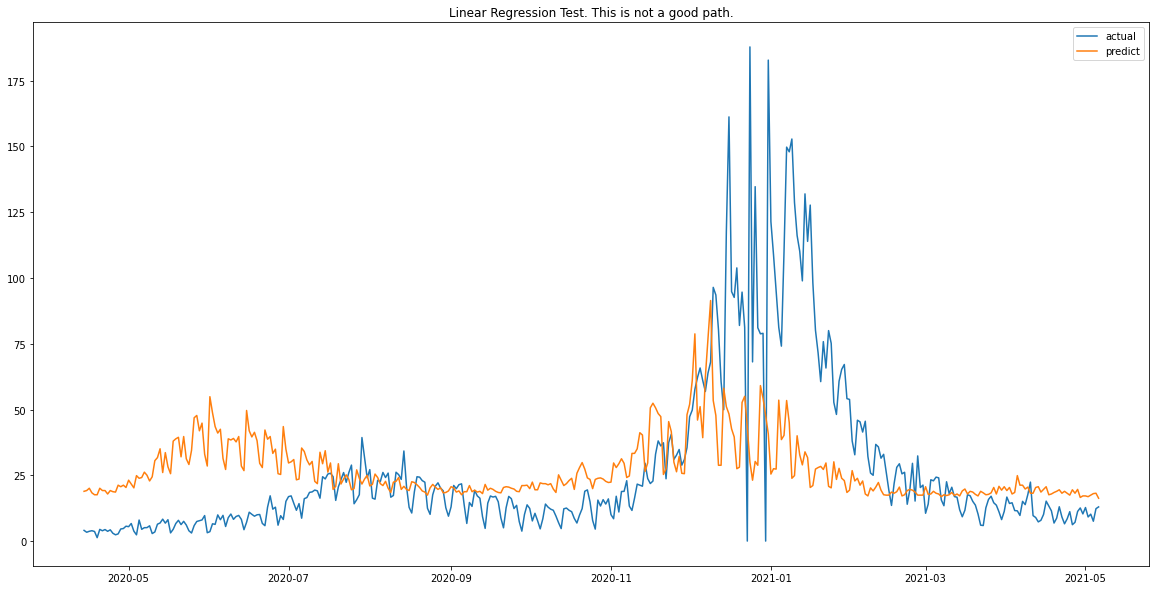

In [29]:


x = imperial_df['state_latino_cases'].values.reshape(-1, 1)
y = imperial_df['cases'].values


x = ca_race_df[ca_race_df['race'] == 'Latino']['cases_100k'].values.reshape(-1, 1)
y = ca_100k_df[ca_100k_df['county'] == 'Imperial']['cases'].values


x = ca_100k_df[ca_100k_df['county'] == 'Imperial']['cases'].values.reshape(-1, 1)
y = ca_race_df[ca_race_df['race'] == 'Latino']['cases_100k'].values

plt.rcParams['figure.figsize'] = [20,10]
#model = LinearRegression().fit([ imperial_df['state_latino_cases'] ], [ imperial_df['cases'] ])
model = LinearRegression().fit(x,y)

print(model.score(x,y))


#model.predict([ imperial_df['state_latino_cases'] ])

#print(model.score([ imperial_df['state_latino_cases'] ], [ imperial_df['cases'] ]))

#print((model.predict([ imperial_df['state_latino_cases'] ])[0]))
print(model.coef_)
print(model.intercept_)


fig,ax = plt.subplots()
ax.plot(ca_100k_df['date'].unique(),y,label='actual')
ax.plot(ca_100k_df['date'].unique(),model.predict(x),label='predict')
#ax.plot(ca_100k_df['date'].unique(),y,label='state')
#ax.plot(ca_100k_df['date'].unique(),x,label='county')
plt.title("Linear Regression Test. This is not a good path.")
plt.legend()
plt.show()

In [30]:
print(ca_100k_df)
print(ca_covid_df)
print(ca_race_df)

            date    county     cases    deaths  total_tests  population   Latino    White    Asian    Black   Native  Hawaiian  Multiracial
0     2020-04-14     Kings  2.615405  0.000000    32.038708     1.52940  0.84514  0.47938  0.05787  0.09662  0.01351   0.00311      0.03377
1     2020-04-14   Ventura  2.482252  0.000000    32.623882     8.46006  3.65835  3.78024  0.62677  0.15115  0.02452   0.01518      0.20385
2     2020-04-14  Tuolumne  0.000000  0.000000    44.054481     0.54478  0.06906  0.43425  0.00714  0.01007  0.00813   0.00116      0.01497
3     2020-04-14    Tulare  7.936593  0.429005    35.178412     4.66195  3.05824  1.28955  0.15337  0.05737  0.03195   0.00457      0.06690
4     2020-04-14   Trinity  0.000000  0.000000     0.000000     0.12285  0.00907  0.10060  0.00173  0.00070  0.00502   0.00027      0.00546
...          ...       ...       ...       ...          ...         ...      ...      ...      ...      ...      ...       ...          ...
22499 2021-05-06    

In [31]:
print(ca_model_cases_df)

            date    county  cases  deaths  total_tests  population    Latino     White     Asian     Black    Native  Hawaiian  Multiracial  case_Native  case_Asian  case_Black  case_Latino  \
0     2020-04-14     Kings    4.0     0.0         49.0      152940  0.552596  0.313443  0.037838  0.063175  0.008834  0.002033     0.022081     0.035334    0.151353    0.252700     2.210383   
1     2020-04-14   Ventura   21.0     0.0        276.0      846006  0.432426  0.446834  0.074086  0.017866  0.002898  0.001794     0.024096     0.060865    1.555801    0.375192     9.080946   
2     2020-04-14  Tuolumne    0.0     0.0         24.0       54478  0.126767  0.797111  0.013106  0.018485  0.014923  0.002129     0.027479     0.000000    0.000000    0.000000     0.000000   
3     2020-04-14    Tulare   37.0     2.0        164.0      466195  0.656000  0.276612  0.032898  0.012306  0.006853  0.000980     0.014350     0.253574    1.217235    0.455322    24.272006   
4     2020-04-14   Trinity    0.0  

In [102]:
#//*** Build: ca_cases_broad_df
#//*** Each County as a column with COVID Cases by date
this_df = ca_model_cases_df

case_col_col = 'cases'

broad_case_dict = {}
for group in this_df[['date','county',case_col_col]].groupby('date'):
    
    #//*** Initialize the dict
    if len(broad_case_dict.keys()) == 0:
        broad_case_dict['date'] = []
        broad_case_dict['total'] = []
        newcols = list(group[1][['county',case_col_col]].transpose().iloc[0])
        for col in newcols:
            broad_case_dict[col] = []
           
    #//*** Add Date
    broad_case_dict['date'].append(group[0])
    broad_case_dict['total'].append(group[1][case_col_col].sum())
    loop_df = group[1][['county',case_col_col]].transpose() 
    loop_df.columns = newcols
    
    for col in newcols:
        broad_case_dict[col].append((loop_df[col].iloc[1]))

ca_cases_broad_df = pd.DataFrame()

ca_cases_broad_df['date'] = broad_case_dict['date']
ca_cases_broad_df['total'] = broad_case_dict['total']
for col in ts.index.values:
    ca_cases_broad_df[col] = broad_case_dict[col]

print(ca_cases_broad_df)



#//*** Build: ca_cases_broad_df
#//*** Each Statewide Race as a column with COVID Cases by date
broad_race_dict = {}
for group in ca_race_df[['date','race','cases']].groupby('date'):
    #print(group[1])
    
    #//*** Initialize the dict
    if len(broad_race_dict.keys()) == 0:
        broad_race_dict['date'] = []
        newcols = list(group[1].transpose().iloc[1])
        for col in newcols:
            broad_race_dict[col] = []

    
    #//*** Add Date
    broad_race_dict['date'].append(group[0])
    
    loop_df = group[1].transpose()
    loop_df.columns = newcols
    #print(loop_df)
    for col in newcols:
        broad_race_dict[col].append(int(loop_df[col].loc['cases']))

ca_races_broad_df = pd.DataFrame()

for key,value in broad_race_dict.items():
    ca_races_broad_df[key] = value

print(ca_races_broad_df)
    

    

          date   total  Imperial  Kings  San Bernardino  Los Angeles  Riverside  Merced  Kern  Madera  Tulare  Fresno  Stanislaus  Monterey  Ventura  San Joaquin  San Diego  Orange  Santa Barbara  \
0   2020-04-14  1470.0      18.0    4.0            74.0        712.0      140.0     1.0  25.0     2.0    37.0    22.0         6.0       6.0     21.0         14.0       83.0    69.0           19.0   
1   2020-04-15  1647.0       0.0    0.0            54.0          1.0        9.0     0.0   4.0     6.0     4.0     0.0        23.0       1.0      3.0         20.0       34.0     0.0           98.0   
2   2020-04-16  1659.0       0.0    0.0             0.0          4.0        9.0     1.0   0.0     0.0     1.0     0.0        17.0       0.0      0.0          8.0        1.0    69.0           19.0   
3   2020-04-17  1588.0       0.0    3.0           108.0          2.0        8.0     6.0   4.0     4.0     5.0     0.0         0.0       0.0      0.0          4.0       63.0     2.0           25.0   
4   2

In [107]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


from sklearn.inspection import permutation_importance

def rfr_model(X, y):# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,10),
            'n_estimators': (10, 50, 100, 200, 300, 400),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_

    print(best_params)

    #//*** Return the model with best parameters
    return RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)

race_coef_df = pd.DataFrame()

#//*** Build a table of Modeled Racial co-efficients for the past 30 days
races = list(ca_races_broad_df.columns[1:])

#for race in races:
for race in races:

    
    #//*** Fit a Random forest Regression for the past 30 days
    #https://medium.datadriveninvestor.com/random-forest-regression-9871bc9a25eb
    # Fitting Random Forest Regression to the dataset
    # import the regressor


    x_col_index = 4
    modeling_days = -30

    
    model_df = ca_races_broad_df[['date',race]].merge(ca_race_diff[['date',race]],left_on='date', right_on='date').merge(ca_cases_broad_df, left_on='date', right_on='date')[modeling_days:]
    #print(model_df.head(1))
    #//*** Get the Columns for the X dataframe.
    #//*** The X Value is the index where the attributes start, there are 58 of them :)
    x_column = model_df.columns[x_col_index:]
    
    #//*** Define the X attributes and 
    x_model = model_df[x_column]
    #x_model = preprocessing.scale(x_model) 
    y_column = model_df.columns[1]
    y_model = model_df[y_column]




    regressor =rfr_model(x_model,y_model)

    # Perform K-Fold CV
    scores = cross_val_score(regressor, x_model, y_model, cv=10, scoring='neg_mean_squared_error')

    # fit the regressor with x and y data
    regressor.fit(x_model, y_model)  


    y_predict = regressor.predict(x_model)

    pred_df = pd.DataFrame()
    
    pred_df['actual'] = list(y_model)
    pred_df['predict'] = y_predict
    
    
    
    start_time = time.time()
    result = permutation_importance(
        regressor, x_model, y_model, n_repeats=10, random_state=0, n_jobs=-1)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: "
          f"{elapsed_time:.3f} seconds")
    index = ['race'] + list(model_df.columns[x_col_index:])
    data = [race] + list(result.importances_mean)
    forest_importances = pd.Series(data, index=index).to_frame().transpose()

    #calculate RMSE
    rmse = sqrt(mean_squared_error(pred_df['actual'], pred_df['predict'])) 
    #print(pred_df)
    print(race, " - RMSE: ",rmse)
    
    #print("Forest:",forest_importances)
    #print(pred_df)
    race_coef_df = pd.concat([race_coef_df,forest_importances])

    

print(race_coef_df)


{'max_depth': 5, 'n_estimators': 100}
Elapsed time to compute the importances: 0.522 seconds
Native  - RMSE:  2.9665516080869065
{'max_depth': 5, 'n_estimators': 200}
Elapsed time to compute the importances: 0.915 seconds
Asian  - RMSE:  50.45970745545771
{'max_depth': 3, 'n_estimators': 50}
Elapsed time to compute the importances: 0.302 seconds
Black  - RMSE:  33.9292360782713
{'max_depth': 7, 'n_estimators': 10}
Elapsed time to compute the importances: 0.151 seconds
Latino  - RMSE:  310.4951557444025
{'max_depth': 5, 'n_estimators': 10}
Elapsed time to compute the importances: 0.151 seconds
Multiracial  - RMSE:  22.105704512643474
{'max_depth': 3, 'n_estimators': 10}
Elapsed time to compute the importances: 0.143 seconds
Hawaiian  - RMSE:  6.336014729182313
{'max_depth': 4, 'n_estimators': 50}
Elapsed time to compute the importances: 0.322 seconds
White  - RMSE:  128.02808850353946
          race    Imperial       Kings San Bernardino Los Angeles   Riverside       Merced         Kern

In [167]:
print(model_df)

          date  Latino_x  Latino_y   total  Imperial  Kings  San Bernardino  Los Angeles  Riverside  Merced  Kern  Madera  Tulare  Fresno  Stanislaus  Monterey  Ventura  San Joaquin  San Diego  \
358 2021-04-07      2351  0.419882  2598.0       3.0   47.0            46.0        507.0      207.0     2.0  10.0    19.0     4.0    63.0         0.0      28.0     20.0         47.0       11.0   
359 2021-04-08      2159  0.335428  2223.0       4.0    5.0           118.0          0.0      111.0     1.0  18.0   429.0    68.0     3.0         1.0      80.0     50.0         69.0      221.0   
360 2021-04-09      2754  0.260879  2242.0       2.0   20.0            99.0        491.0      109.0     2.0  37.0    12.0    49.0    64.0         0.0     107.0      0.0         70.0        9.0   
361 2021-04-10      3490  0.341868  1782.0       0.0   13.0           153.0        355.0       81.0     1.0  34.0     3.0    33.0     0.0         1.0       7.0      0.0         12.0       85.0   
362 2021-04-11      

In [188]:

race_coef_df = pd.DataFrame()

from sklearn import linear_model

#//*** Build a table of Modeled Racial co-efficients for the past 30 days
races = list(ca_races_broad_df.columns[1:])

for race in races:
#for race in ['Latino']:

    
    #//*** Fit a Random forest Regression for the past 30 days
    #https://medium.datadriveninvestor.com/random-forest-regression-9871bc9a25eb
    # Fitting Random Forest Regression to the dataset
    # import the regressor


    x_col_index = 4
    modeling_days = -30
    

    
    model_df = ca_races_broad_df[['date',race]].merge(ca_race_diff[['date',race]],left_on='date', right_on='date').merge(ca_cases_broad_df, left_on='date', right_on='date')[modeling_days:]
    #print(model_df.head(1))
    #//*** Get the Columns for the X dataframe.
    #//*** The X Value is the index where the attributes start, there are 58 of them :)
    x_column = model_df.columns[x_col_index:]
    
    #//*** Define the X attributes and 
    x_model = model_df[x_column]
    #x_model = preprocessing.scale(x_model) 
    y_column = model_df.columns[1]
    y_model = model_df[y_column]

    regr = linear_model.LinearRegression()
    regr.fit(x_model, y_model)

    y_predict = regr.predict(x_model)

    pred_df = pd.DataFrame()
    
    pred_df['actual'] = list(y_model)
    pred_df['predict'] = y_predict
    
    
    #calculate RMSE
    rmse = sqrt(mean_squared_error(pred_df['actual'], pred_df['predict'])) 
    
    index = ['race','intercept'] + list(model_df.columns[x_col_index:])
    data = [race,regr.intercept_] + list(regr.coef_)

    #calculate RMSE
    rmse = sqrt(mean_squared_error(pred_df['actual'], pred_df['predict'])) 
    race_coef_df = pd.concat([race_coef_df,pd.Series(data, index=index).to_frame().transpose()])

print(ca_races_broad_df[-30:-29])
print(ca_cases_broad_df[-30:-29])

print(race_coef_df)
    

          date  Native  Asian  Black  Latino  Multiracial  Hawaiian  White
358 2021-04-07       7    260    157    2351          133        24    780
          date   total  Imperial  Kings  San Bernardino  Los Angeles  Riverside  Merced  Kern  Madera  Tulare  Fresno  Stanislaus  Monterey  Ventura  San Joaquin  San Diego  Orange  Santa Barbara  \
358 2021-04-07  2598.0       3.0   47.0            46.0        507.0      207.0     2.0  10.0    19.0     4.0    63.0         0.0      28.0     20.0         47.0       11.0   109.0           13.0   

     San Luis Obispo  Solano  Napa  Shasta  Sacramento   Yolo  Santa Clara  Sonoma  Santa Cruz  Contra Costa  Placer  Butte  San Mateo  Marin  El Dorado  Alameda  San Francisco  Humboldt  
358             20.0     0.0   4.0     6.0         9.0  114.0          0.0    42.0        84.0           3.0     9.0    1.0      260.0    0.0       28.0      8.0           18.0      34.0  
          race intercept  Imperial     Kings San Bernardino Los Angeles  

In [190]:
print(race_coef_df['Imperial']*3)

#Target Deaths: 2351
#LA Deaths: 507
#LA COEF:  -1.86145819
#inter: 2024


0    0.668577
0     24.9988
0    -2.61613
0    -25.8728
0     1.65222
0     1.65402
0     3.05765
Name: Imperial, dtype: object


In [194]:
print("Native: ",0.668577 + 12)
print("Native: ",(0.668577 + 12)/12)

print("Latino: ",-25.8728 + 2024)
print("Latino: ",(-25.8728 + 2024)/2024)

Native:  12.668576999999999
Native:  1.05571475
Latino:  1998.1272
Latino:  0.9872169960474307


In [42]:
"""#//*** Modeling
#//*** Predict total Statewide cases from County Cases. This gives a county COVID weight.
#//*** Predict total Racial Cases from county Cases. This gives a county racial weight. The difference between the total prediction
#//*** And the racial prediction whould be the racial case count for the county. May have to the regression in reverse with the county weights.

#//*** Assemble Each County cases_100k
x = []
for county in ca_100k_df['county'].unique():
    x.append(ca_100k_df[ca_100k_df['county']==county]['cases'].values)


x = np.array(x).reshape(-1,58)    
#//**** Predict Statewide Cases
y = ca_total_df['cases_100k']

print(len(x))
print(len(y))

model = LinearRegression().fit(x,y)

print(model.score(x,y))

models_df = pd.DataFrame()
models_df['county'] = ca_100k_df['county'].unique()
models_df['state_100k'] = model.coef_
print(models_df)
print(model.intercept_)

#x = np.array(x).reshape(-1,58)    
#//**** Predict Statewide Cases
#y = ca_total_df['cases_100k']

#print(len(x))
#print(len(y))
print(x_model.shape)
print(x_model)
model = LinearRegression().fit(np.array(x_model).reshape(-1,1)  ,np.array(y_model).reshape(-1,1))

print(model.score(x_model,x_model))
"""

"#//*** Modeling\n#//*** Predict total Statewide cases from County Cases. This gives a county COVID weight.\n#//*** Predict total Racial Cases from county Cases. This gives a county racial weight. The difference between the total prediction\n#//*** And the racial prediction whould be the racial case count for the county. May have to the regression in reverse with the county weights.\n\n#//*** Assemble Each County cases_100k\nx = []\nfor county in ca_100k_df['county'].unique():\n    x.append(ca_100k_df[ca_100k_df['county']==county]['cases'].values)\n\n\nx = np.array(x).reshape(-1,58)    \n#//**** Predict Statewide Cases\ny = ca_total_df['cases_100k']\n\nprint(len(x))\nprint(len(y))\n\nmodel = LinearRegression().fit(x,y)\n\nprint(model.score(x,y))\n\nmodels_df = pd.DataFrame()\nmodels_df['county'] = ca_100k_df['county'].unique()\nmodels_df['state_100k'] = model.coef_\nprint(models_df)\nprint(model.intercept_)\n\n#x = np.array(x).reshape(-1,58)    \n#//**** Predict Statewide Cases\n#y = c

In [39]:

#//**** Let's try modeling just Latinos and see what happens
broad_latino_df = ca_races_broad_df[['date','Latino']].merge(ca_race_diff[['date','Latino']],left_on='date', right_on='date').merge(ca_cases_broad_df, left_on='date', right_on='date')
#print(broad_latino_df.shape)

#print( broad_latino_df.columns[2:])
#print(y_model)
print(broad_latino_df)


          date  Latino_x  Latino_y       total   Imperial     Kings  San Bernardino  Los Angeles  Riverside     Merced       Kern     Madera     Tulare     Fresno  Stanislaus   Monterey   Ventura  \
0   2020-04-14       634  0.232160  657.456162  15.305488  2.210383       40.284572   346.242215  70.043011   0.610206  13.650964   1.175679  24.272006  11.828594    2.855497   3.562462  9.080946   
1   2020-04-15       523  0.154362  737.778286   0.000000  0.000000        8.227207     0.587839   2.126774   0.000000   0.651557   3.661236   1.276952   0.000000   15.088004   0.552596  0.818306   
2   2020-04-16       580  0.188535  738.992600   0.000000  0.000000        0.000000     2.210383   2.126774   0.257974   0.000000   0.000000   0.273001   0.000000   11.152003   0.000000  0.000000   
3   2020-04-17       614  0.267495  713.281369   0.000000  1.427749       36.881783     1.175679   1.890465   3.661236   2.210383   0.651557   1.365003   0.000000    0.000000   0.000000  0.000000   
4   2

In [43]:
#https://medium.datadriveninvestor.com/random-forest-regression-9871bc9a25eb
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.inspection import permutation_importance

x_col_index = 4

model_df = broad_latino_df

x_column = model_df.columns[x_col_index:]
x_model = model_df[x_column]/model_df[x_column].max()
x_model = model_df[x_column][-30:]


#x_model = preprocessing.scale(x_model) 
y_column = model_df.columns[1]
y_model = model_df[y_column][-30:]


def rfr_model(X, y):# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,10),
            'n_estimators': (10, 50, 100, 200, 300, 400),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,                         n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    print(best_params)
    
    #//*** Return the model with best parameters
    return RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)

    
regressor =rfr_model(x_model,y_model)

# Perform K-Fold CV
scores = cross_val_score(regressor, x_model, y_model, cv=10, scoring='neg_mean_squared_error')

#print("Scores: ",scores)
  
# fit the regressor with x and y data
regressor.fit(x_model, y_model)  


y_predict = regressor.predict(x_model)
pred_df = pd.DataFrame()
pred_df['actual'] = y_model
pred_df['predict'] = y_predict

start_time = time.time()
result = permutation_importance(
    regressor, x_model, y_model, n_repeats=10, random_state=0, n_jobs=-1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=model_df.columns[x_col_index:])
print(forest_importances.transpose())

#print(x_model)

#calculate RMSE
rmse = sqrt(mean_squared_error(pred_df['actual'], pred_df['predict'])) 
print("RMSE: ",rmse)
print(pred_df)



{'max_depth': 7, 'n_estimators': 100}
Elapsed time to compute the importances: 0.543 seconds
Imperial           0.613900
Kings              0.009901
San Bernardino     0.001358
Los Angeles        0.056548
Riverside          0.010748
Merced             0.010694
Kern               0.045609
Madera             0.011670
Tulare             0.018210
Fresno             0.017397
Stanislaus         0.011105
Monterey           0.010829
Ventura            0.007333
San Joaquin        0.018261
San Diego          0.021793
Orange             0.015007
Santa Barbara      0.012446
San Luis Obispo    0.003797
Solano             0.005562
Napa               0.047365
Shasta             0.061150
Sacramento         0.020078
Yolo               0.010290
Santa Clara        0.004454
Sonoma             0.004783
Santa Cruz         0.009517
Contra Costa       0.003897
Placer             0.007339
Butte              0.010016
San Mateo          0.009879
Marin              0.003895
El Dorado          0.001310
Alameda    

In [44]:
for index,value in forest_importances.items():
    print(index,value)
    

Imperial 0.6139004887076093
Kings 0.009900895242888851
San Bernardino 0.0013578445383295335
Los Angeles 0.05654813688203657
Riverside 0.010748219360764444
Merced 0.010694359502215423
Kern 0.04560900101473129
Madera 0.01167036857604431
Tulare 0.01820950002910713
Fresno 0.017397334924419472
Stanislaus 0.01110503994918698
Monterey 0.010828943005038682
Ventura 0.007332504448870625
San Joaquin 0.01826056832336027
San Diego 0.02179349176522849
Orange 0.015007198024329916
Santa Barbara 0.012445665840819898
San Luis Obispo 0.003796992033694657
Solano 0.005561594913865553
Napa 0.047365188219877896
Shasta 0.06115029579071318
Sacramento 0.020077846563262402
Yolo 0.010290313834360165
Santa Clara 0.004453587412836679
Sonoma 0.004782919860347778
Santa Cruz 0.009516945806245236
Contra Costa 0.003897266163640933
Placer 0.007338530489048067
Butte 0.010016438558030827
San Mateo 0.009878734139056423
Marin 0.003895426444072414
El Dorado 0.001310481869432656
Alameda 0.007598710176572321
San Francisco 0.027

In [45]:
#https://medium.datadriveninvestor.com/random-forest-regression-9871bc9a25eb
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
  


model_df = broad_latino_df

x_column = model_df.columns[3:]
x_model = model_df[x_column]/model_df[x_column].max()
x_model = model_df[x_column]
#x_model = preprocessing.scale(x_model) 
y_column = model_df.columns[1]
y_model = model_df[y_column]


def rfr_model(X, y):# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,10),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,                         n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    print(best_params)
    
    #//*** Return the model with best parameters
    return RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)

    
regressor =rfr_model(x_model,y_model)

# Perform K-Fold CV
scores = cross_val_score(regressor, x_model, y_model, cv=10, scoring='neg_mean_squared_error')

print("Scores: ",scores)
  
# fit the regressor with x and y data
regressor.fit(x_model, y_model)  

y_predict = regressor.predict(x_model)

pred_df = pd.DataFrame([y_model,y_predict]).transpose()
pred_df.columns = ['actual','predict']


start_time = time.time()
result = permutation_importance(
    regressor, x_model, y_model, n_repeats=10, random_state=0, n_jobs=-1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=model_df.columns[3:])
print(forest_importances)

from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
rmse = sqrt(mean_squared_error(pred_df['actual'], pred_df['predict'])) 

print(pred_df)
print("RMSE: ",rmse)

{'max_depth': 8, 'n_estimators': 10}
Scores:  [  -972237.92947902  -4788798.95628158  -3674732.62339791
  -1547239.7202319   -1035613.80876965 -49396211.88946133
 -67700406.15995833 -19182325.22070103  -1487706.54794637
   -555342.10969236]
Elapsed time to compute the importances: 0.171 seconds
total              1.286836
Imperial           0.035063
Kings              0.001301
San Bernardino     0.000473
Los Angeles        0.003221
Riverside          0.004363
Merced             0.038296
Kern               0.002089
Madera             0.000791
Tulare             0.004687
Fresno             0.020253
Stanislaus         0.015907
Monterey           0.007888
Ventura            0.012635
San Joaquin        0.008863
San Diego          0.014426
Orange             0.016871
Santa Barbara      0.009652
San Luis Obispo    0.021800
Solano             0.005730
Napa               0.006513
Shasta             0.001055
Sacramento         0.022035
Yolo               0.000759
Santa Clara        0.003629
Sono

In [46]:
#https://oindrilasen.com/2021/02/how-to-install-and-import-keras-in-anaconda-jupyter-notebooks/

from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing 
from sklearn.preprocessing import scale

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix

import tensorflow as tf
import time

In [47]:
# //*** Reference Code: Applied Text Analysys with Python p282.
metric_dict = {}

metrics = ['total_features',]

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

def baseline_model():
    """
    Create a function that returns a compiled neural network
    """
    model = Sequential()
    
    #//*** First Layer. 
    model.add(Dense(500, input_dim=LAYER_1, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, input_dim=LAYER_1, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, input_dim=LAYER_1, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
    return model
    
    #nn.add(Dense(N_FEATURES, activation='relu', input_shape=(N_FEATURES,)))
    #nn.add(Dense(N_FEATURES*SECOND_LAYER_SIZE, activation='relu'))
    #nn.add(Dense(N_CLASSES, activation='softmax'))
    #nn.compile(
    #    loss='categorical_crossentropy',
    #    optimizer='adam',
    #    metrics=['accuracy']
    #)
    #return nn

model_df = broad_latino_df

x_column = model_df.columns[2:]
x_model = model_df[x_column]/model_df[x_column].max()
x_model = model_df[x_column]
#x_model = preprocessing.scale(x_model) 
y_column = model_df.columns[1]
y_model = model_df[y_column]

#y_model = model_df[y_column]/model_df[y_column].max()

LAYER_1 = x_model.shape[1]

#x_model = preprocessing.scale(x_model) 
#scaler = preprocessing.StandardScaler().fit(x_train) 
#x_test_scaled = scaler.transform(x_test)

"""
regressor = Pipeline([
#  ('norm', TextNormalizer()),
#  ('vect', TfidfVectorizer(max_features=N_FEATURES)),
 ('nn', KerasClassifier(build_fn=baseline_model,
 epochs=100,
 verbose=0,              
batch_size=128))
 ])
"""

model = Sequential()

#//*** First Layer. 
#model.add(Dense(LAYER_1, input_dim=LAYER_1, kernel_initializer='normal', activation='relu'))
model.add(Dense(LAYER_1, input_dim=LAYER_1, activation='relu'))
#model.add(Dense(int(LAYER_1*.5), input_dim=500, kernel_initializer='normal', activation='relu'))
#model.add(Dense(50, input_dim=50, kernel_initializer='normal', activation='relu'))
model.add(Dense(1))
# Compile model
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

start_time = time.time()

#print(model.get_weights())

model.fit(x_model,y_model,epochs=1000,verbose=0,batch_size=128)

model_run_time = time.time() - start_time 

y_predicted = np.argmax(model.predict(x_model), axis=-1)
print(y_model,y_predicted)
#precision = precision_score(y_model, y_predicted, average='micro')
accuracy = accuracy_score(y_model, y_predicted)
#recall = recall_score(y_model, y_predicted, average ='micro')



print(model.evaluate(x_model,y_predicted))
print("========")
#print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
#print(f"Recall: {recall}")

#print(y_predicted)

0       634
1       523
2       580
3       614
4       568
       ... 
383    1428
384    1594
385    1175
386    1919
387    2024
Name: Latino_x, Length: 388, dtype: int64 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13/13 [==============================]

In [48]:
#Tutorial Code from:
#https://www.tutorialspoint.com/keras/keras_regression_prediction_using_mpl.htm
import keras 
import tensorflow as tf

from keras.datasets import boston_housing 
from keras.models import Sequential 
from keras.layers import Dense 

from tensorflow.keras.optimizers import RMSprop 
#from keras.optimizers import RMSprop
#from keras.optimizers import RMSprop 
from keras.callbacks import EarlyStopping 
from sklearn import preprocessing 
from sklearn.preprocessing import scale

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

x_train_scaled = preprocessing.scale(x_train) 
scaler = preprocessing.StandardScaler().fit(x_train) 
x_test_scaled = scaler.transform(x_test)

print(x_train)

print(x_train)
"""
model = Sequential() 
model.add(Dense(64, kernel_initializer = 'normal', activation = 'relu',
input_shape = (13,))) 
model.add(Dense(64, activation = 'relu')) 
model.add(Dense(1))

model.compile(
   loss = 'mse', 
   #optimizer = RMSprop, 
   metrics = ['mean_absolute_error']
)

history = model.fit(
   x_train_scaled, y_train,    
   batch_size=128, 
   epochs = 500, 
   verbose = 1, 
   validation_split = 0.2, 
   callbacks = [EarlyStopping(monitor = 'val_loss', patience = 20)]
)

score = model.evaluate(x_test_scaled, y_test, verbose = 0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(x_test_scaled) 
print(prediction.flatten()) 
print(y_test)
"""

57344/57026 [==============================] - 0s 1us/step
[[1.23247e+00 0.00000e+00 8.14000e+00 ... 2.10000e+01 3.96900e+02
  1.87200e+01]
 [2.17700e-02 8.25000e+01 2.03000e+00 ... 1.47000e+01 3.95380e+02
  3.11000e+00]
 [4.89822e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.75520e+02
  3.26000e+00]
 ...
 [3.46600e-02 3.50000e+01 6.06000e+00 ... 1.69000e+01 3.62250e+02
  7.83000e+00]
 [2.14918e+00 0.00000e+00 1.95800e+01 ... 1.47000e+01 2.61950e+02
  1.57900e+01]
 [1.43900e-02 6.00000e+01 2.93000e+00 ... 1.56000e+01 3.76700e+02
  4.38000e+00]]
[[1.23247e+00 0.00000e+00 8.14000e+00 ... 2.10000e+01 3.96900e+02
  1.87200e+01]
 [2.17700e-02 8.25000e+01 2.03000e+00 ... 1.47000e+01 3.95380e+02
  3.11000e+00]
 [4.89822e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.75520e+02
  3.26000e+00]
 ...
 [3.46600e-02 3.50000e+01 6.06000e+00 ... 1.69000e+01 3.62250e+02
  7.83000e+00]
 [2.14918e+00 0.00000e+00 1.95800e+01 ... 1.47000e+01 2.61950e+02
  1.57900e+01]
 [1.43900e-02 6.00000e+01 2.93000e+00 .

"\nmodel = Sequential() \nmodel.add(Dense(64, kernel_initializer = 'normal', activation = 'relu',\ninput_shape = (13,))) \nmodel.add(Dense(64, activation = 'relu')) \nmodel.add(Dense(1))\n\nmodel.compile(\n   loss = 'mse', \n   #optimizer = RMSprop, \n   metrics = ['mean_absolute_error']\n)\n\nhistory = model.fit(\n   x_train_scaled, y_train,    \n   batch_size=128, \n   epochs = 500, \n   verbose = 1, \n   validation_split = 0.2, \n   callbacks = [EarlyStopping(monitor = 'val_loss', patience = 20)]\n)\n\nscore = model.evaluate(x_test_scaled, y_test, verbose = 0) \nprint('Test loss:', score[0]) \nprint('Test accuracy:', score[1])\n\nprediction = model.predict(x_test_scaled) \nprint(prediction.flatten()) \nprint(y_test)\n"

In [49]:
#//*** Assigns a color from a palette list to a county. 
def assign_color(input_item, input_cd,input_palette):
    #//*** Check if item already exists, if so, return input_cd
    if input_item in input_cd.keys():
        return input_cd
    
    #//*** input_item needs a Color. Walk down the input_palette till one is not found
    for color in input_palette:
        if color not in input_cd.values():
            input_cd[input_item] = color
            return input_cd
    print("UH OH ran out of colors!!!")
    print(f"Item: {input_item}")
    print(input_cd)
    return input_cd

In [50]:
#//*** Color Choices: Tucking these aside for later use
#//*** Combine these with a dictionary to create color continuity across multiple visualizations.
color_palette = ["#c6eaff","#caa669","#14bae2","#f7cd89","#98a9e7","#e2ffb7","#cb9ec2","#77dcb5","#ffc5b7","#40bdba","#fff4b0","#74d0ff","#e4da8d","#7ceeff","#d0e195","#b7ab8c","#fcffdb","#83b88d","#ffe2c0","#abc37a"]
color_palette = ["#557788","#e12925","#44af0e","#7834c0","#726d00","#130c6d","#004e12","#f7007d","#017878","#950089","#00a3d7","#4b000e","#0063c2","#f07478","#013b75","#cf81b8","#212238","#af87e7","#320f49","#9c91db"]
county_color_palette = ["#b4a23b","#4457ca","#9ec535","#a651cb","#59ce59","#6a77f0","#52a325","#b93d9b","#36b25c","#e374d4","#c1c035","#7452af","#96ae3a","#a484e2","#89c466","#e54790","#57c888","#dd3d60","#5bd6c4","#dd4e2d","#45ccdf","#bd3738","#4cb998","#b13a6c","#368433","#588feb","#dcad3d","#4763af","#e49132","#4aa5d4","#c86321","#7695d3","#769233","#925898","#54701c","#c893d6","#3d7b44","#e084ac","#65a76b","#965179","#296437","#e57f5f","#31a8ad","#a44b2c","#368d71","#df7f81","#226a4d","#96465f","#b5b671","#68649c","#ad772e","#a34f52","#758348","#d8a06e","#505e25","#8e5e31","#8e8033","#695f1b"]
county_color_palette = ["#96465f","#dd3d60","#df7f81","#a34f52","#bd3738","#dd4e2d","#e57f5f","#a44b2c","#c86321","#8e5e31","#d8a06e","#e49132","#ad772e","#dcad3d","#b4a23b","#8e8033","#695f1b","#c1c035","#b5b671","#96ae3a","#505e25","#758348","#9ec535","#769233","#54701c","#52a325","#89c466","#368433","#59ce59","#3d7b44","#65a76b","#296437","#36b25c","#57c888","#226a4d","#368d71","#4cb998","#5bd6c4","#31a8ad","#45ccdf","#4aa5d4","#7695d3","#588feb","#4763af","#6a77f0","#4457ca","#68649c","#a484e2","#7452af","#a651cb","#c893d6","#925898","#e374d4","#b93d9b","#965179","#e084ac","#e54790","#b13a6c"]
county_color_palette = ["#226a4d","#31a8ad","#68649c","#758348","#505e25","#368d71","#4aa5d4","#965179","#7695d3","#45ccdf","#296437","#96465f","#8e5e31","#b5b671","#d8a06e","#a34f52","#5bd6c4","#695f1b","#4cb998","#df7f81","#3d7b44","#e084ac","#c893d6","#65a76b","#8e8033","#925898","#4763af","#54701c","#ad772e","#a44b2c","#e57f5f","#769233","#57c888","#b13a6c","#588feb","#a484e2","#b4a23b","#368433","#89c466","#7452af","#96ae3a","#dcad3d","#bd3738","#36b25c","#e374d4","#c86321","#b93d9b","#e49132","#dd3d60","#e54790","#c1c035","#4457ca","#6a77f0","#52a325","#9ec535","#dd4e2d","#a651cb","#59ce59"]

In [51]:
"""#print(ca_covid_df[ca_covid_df['county']=='Imperial'])

print(ca_covid_df.columns[4:])
plt.rcParams['figure.figsize'] = [50,20]
plt.rcParams.update({'figure.max_open_warning': 0})



loop_df = ca_covid_orig_df[ca_covid_orig_df['county']=='Imperial']
display_size = 40
fig,ax = plt.subplots()

for col in ['cases','reported_cases']:

    
    ax.plot(loop_df['date'],loop_df[col].rolling(5).mean(),label=col)


    plt.xticks(rotation=30,fontsize=display_size)
    plt.yticks(fontsize=display_size)
handles,labels = deduplicate_legend(ax)
plt.legend(fontsize=display_size,loc='upper left')
#plt.title(f"Total Covid cases Time Series for all counties.\nLos Angeles County dominates with 29% of the state population (2.5% of the national population)",fontsize=display_size)
#plt.ylabel("Total Cases by County (millions)",fontsize=display_size)
plt.show()

for col in ca_covid_df.columns[4:]:
    display_size = 40
    fig,ax = plt.subplots()
    
    ax.plot(loop_df['date'],loop_df[col],label=col)


    plt.xticks(rotation=30,fontsize=display_size)
    plt.yticks(fontsize=display_size)
    handles,labels = deduplicate_legend(ax)
    plt.legend(fontsize=display_size,loc='upper left')
    #plt.title(f"Total Covid cases Time Series for all counties.\nLos Angeles County dominates with 29% of the state population (2.5% of the national population)",fontsize=display_size)
    #plt.ylabel("Total Cases by County (millions)",fontsize=display_size)
    plt.show()

fig,ax = plt.subplots()
for col in ['deaths','reported_deaths']:

    
    ax.plot(loop_df['date'],loop_df[col].rolling(5).mean(),label=col)


    plt.xticks(rotation=30,fontsize=display_size)
    plt.yticks(fontsize=display_size)
handles,labels = deduplicate_legend(ax)
plt.legend(fontsize=display_size,loc='upper left')
#plt.title(f"Total Covid cases Time Series for all counties.\nLos Angeles County dominates with 29% of the state population (2.5% of the national population)",fontsize=display_size)
#plt.ylabel("Total Cases by County (millions)",fontsize=display_size)
plt.show()
print(ca_covid_df)
"""
print()

Imperial           15492.646856
Kings              14912.383941
San Bernardino     13280.537227
Los Angeles        11737.916530
Riverside          11517.454036
Merced             11073.537885
Kern               10563.851225
Madera             10405.079866
Tulare             10395.864392
Fresno             10116.794999
Stanislaus          9996.367995
Monterey            9845.620777
Ventura             9447.805335
San Joaquin         9353.695083
San Diego           8231.301279
Orange              7911.472523
Santa Barbara       7548.953077
San Luis Obispo     7349.767406
Solano              7170.222700
Napa                7105.935649
Shasta              6637.605509
Sacramento          6636.027777
Yolo                6223.582766
Santa Clara         6045.744175
Sonoma              6010.891378
Santa Cruz          5837.935969
Contra Costa        5834.285486
Placer              5610.688652
Butte               5434.653673
San Mateo           5337.652122
Marin               5317.085610
El Dorad

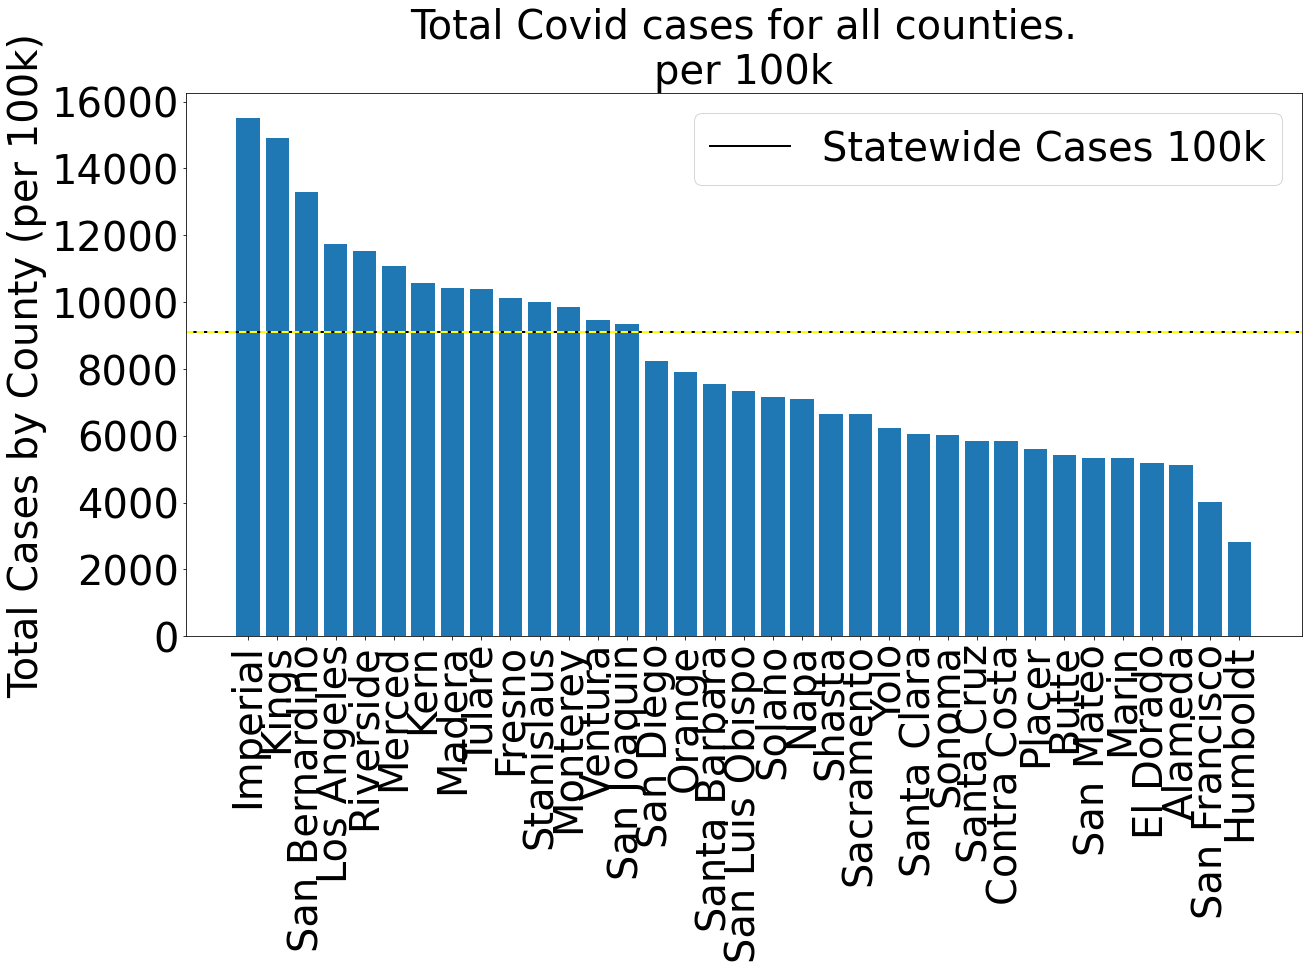

In [52]:
#//*** Get the Statewide 100k value. 
#//*** Get total Case Count from orig_df, dvided by total population / 100000
state_100k = ca_covid_orig_df['cases'].sum()/(ca_covid_orig_df['population'].unique().sum()/100000)

county_list = ca_100k_df['county'].unique()

county_100k = []

for county in county_list:
    if ca_100k_df[ca_100k_df['county']==county].iloc[0]['population'] > 1:
        county_100k.append(county)
case_totals = []

for county in county_100k:
    case_totals.append(ca_100k_df[ca_100k_df['county']==county]['cases'].sum())

#//*** Temp Series
ts = pd.Series(index = county_100k, data=case_totals).sort_values(ascending=False)

print(ts)

display_size = 40
fig,ax = plt.subplots()

ax.bar(ts.index,ts)

#//*** Draw horizontal line. Draw it twice to get the yellow and back effect. 
#//*** This technique looks viusually good, but I can't get the legend to draw approrpriately.
ax.axhline(state_100k,color = "black", label="Statewide Cases 100k", linestyle = "-", lw=2)
ax.axhline(state_100k,color = "yellow", linestyle = "--", lw=2)
        
plt.xticks(rotation=90,fontsize=display_size)
plt.yticks(fontsize=display_size)

#handles,labels = deduplicate_legend(ax)
plt.legend(fontsize=display_size,loc='upper right')
plt.title(f"Total Covid cases for all counties.\nper 100k",fontsize=display_size)
plt.ylabel("Total Cases by County (per 100k)",fontsize=display_size)
plt.show()

In [53]:
#//*** Look at total County COVID numbers by county rates per 100k.


#//*** Get the last data


#for county in






#last_day_df = rd[race_list[0]][rd[race_list[0]]['date'] == last_date]